In [1]:
import numpy as np
from statsmodels.stats.multitest import multipletests
import pandas as pd
import glob
import h5py
import re
from scipy.signal import convolve
from tqdm import tqdm
import scipy.io as sio
import os
import pickle
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import tqdm
import itertools


plt.rc('font', size=20, family='sans-serif') 
plt.rc('axes', linewidth=1.5)
plt.rc('xtick.major', width=1.5, size=6)
plt.rc('ytick.major', width=1.5, size=6)
plt.rc('mathtext', default='regular')

In [2]:
'''load regression info'''

root_dir = '/dartfs-hpc/scratch/f005d7d/what_where_analysis/'
figure_data_dir = '/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/what_where_analysis/what-where-task-analysis/figures'
processed_path = os.path.join(root_dir, 'processed/')

with open(os.path.join(processed_path, 'all_sess_regression_info_with_contr.pkl'), 'rb') as f:
    all_sess_regression_info = pickle.load(f)

In [3]:
'''load original neural data'''

monkey_names = ["W", "V"]
# aligned_events = ["StimOnset", "Choice", "RewFeedback"]
aligned_events = ["StimOnset"]

neural_path = os.path.join(root_dir, 'RasterVec_binSize_10ms/')
bhv_path = os.path.join(root_dir, 'Behavior/')

binsize = 0.01
# gauss_SD = 0.02/binsize
win_size = int(0.05/binsize)
stride = int(0.05/binsize)

all_sess_neural_data = []
all_sess_task_info = []

for event_idx, aligned_event in enumerate(aligned_events):
    for monkey_idx, monkey_name in enumerate(monkey_names):
        files = glob.glob(
            f'{neural_path}/{aligned_event}/RastVect-{monkey_name}*-binsize10ms-align2{aligned_event}.mat')
        for sess_idx in range(len(files)):
            filename = files[sess_idx]

            curr_sess_neural = h5py.File(filename)
            sess_date = re.search(re.compile(
                f'RastVect-{monkey_name}(\\d*)-binsize10ms-align2{aligned_event}.mat'), filename).groups()[0]

#             neural_data = gaussian_filter(curr_sess_neural['aligned2event'], gauss_SD, mode='constant', axes=2)
            neural_data = convolve(curr_sess_neural['aligned2event'], np.ones((1,1,win_size))/win_size, mode='valid')[:,:,::stride]
            
            bhv_filename = bhv_path+'SPKcounts_'+monkey_name+sess_date+'cue_MW_250X250ms.mat'
            curr_sess_bhv = sio.loadmat(
                bhv_path+'SPKcounts_'+monkey_name+sess_date+'cue_MW_250X250ms.mat')
            task_info = curr_sess_bhv['Y']

            # only keep chosen image, chosen loc, reward, block type, 
            # block id (by type), correct choice, block id (by order)
            task_info = task_info[:, [0, 1, 2, 9, 7, 5, 4, 8]].astype(float)

            trial_mask = task_info[:, 4] <= 24
            task_info = task_info[trial_mask]
            
            all_sess_task_info.append(task_info)
            neural_data = neural_data[trial_mask]

            neuron_mask = np.nonzero(np.min(neural_data.sum(0), 1))[0]
            neural_data = neural_data[:, neuron_mask, :]            
            
            all_sess_neural_data.append(neural_data)
            
            print("aligned to: " + aligned_event + ", monkey: " + monkey_name + ", session: " + sess_date)
            

num_timesteps = neural_data.shape[-1]

# filter out units with suspicious activities
unit_idxs = np.ones((all_sess_neural_data[2].shape[1]))
unit_idxs[572] = 0
all_sess_neural_data[2] = all_sess_neural_data[2][:,unit_idxs>0.5]
all_sess_regression_info['pvals'][2] = all_sess_regression_info['pvals'][2][:,unit_idxs>0.5]
all_sess_regression_info['contr_pvals'][2] = all_sess_regression_info['contr_pvals'][2][:,unit_idxs>0.5]
all_sess_regression_info['betas'][2] = all_sess_regression_info['betas'][2][:,unit_idxs>0.5]


unit_idxs = np.ones((all_sess_neural_data[7].shape[1]))
unit_idxs[429] = 0
all_sess_neural_data[7] = all_sess_neural_data[7][:,unit_idxs>0.5]
all_sess_regression_info['pvals'][7] = all_sess_regression_info['pvals'][7][:,unit_idxs>0.5]
all_sess_regression_info['contr_pvals'][7] = all_sess_regression_info['contr_pvals'][7][:,unit_idxs>0.5]
all_sess_regression_info['betas'][7] = all_sess_regression_info['betas'][7][:,unit_idxs>0.5]


aligned to: StimOnset, monkey: W, session: 20160122
aligned to: StimOnset, monkey: W, session: 20160112
aligned to: StimOnset, monkey: W, session: 20160121
aligned to: StimOnset, monkey: W, session: 20160113
aligned to: StimOnset, monkey: V, session: 20160929
aligned to: StimOnset, monkey: V, session: 20160930
aligned to: StimOnset, monkey: V, session: 20161005
aligned to: StimOnset, monkey: V, session: 20161017


In [4]:
def plot_mean_se(ax, xxx, yyy, color, label, axis):
    mean = np.nanmean(yyy, axis)
    se = np.nanstd(yyy, axis)/np.sqrt(yyy.shape[axis])
    ax.plot(xxx, mean, c=color, label=label, lw=3)
    ax.fill_between(xxx, mean-se, mean+se, color=color, alpha=0.2)
    

In [5]:
all_sess_exp_var = np.concatenate(all_sess_regression_info['pvals'], axis=1)<0.05
all_sess_contr_pvals = np.concatenate(all_sess_regression_info['contr_pvals'], axis=1)<0.05
all_sess_betas = np.concatenate(all_sess_regression_info['betas'], axis=1)

num_timesteps = neural_data.shape[-1]
xxx = np.linspace(-1500, 1500-stride*binsize*1000, num=num_timesteps)

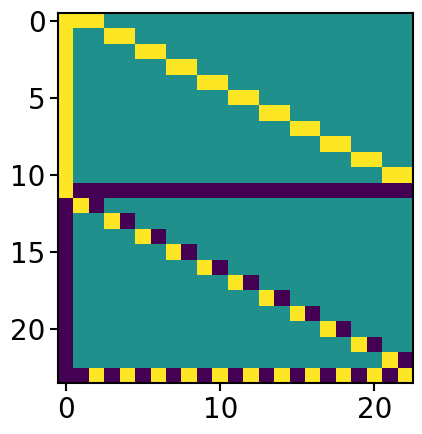

In [6]:
num_blocks_per_type = 12

block_contrasts = np.concatenate([np.ones(12), -np.ones(12)])
img_contrasts = np.concatenate([
    np.eye(num_blocks_per_type-1), -np.ones((1, num_blocks_per_type-1))
])

all_contrasts = np.ones((24,23))*np.nan

all_contrasts[:,0] = block_contrasts
all_contrasts[:num_blocks_per_type,1::2] = img_contrasts
all_contrasts[num_blocks_per_type:,1::2] = img_contrasts
all_contrasts[:num_blocks_per_type,2::2] = img_contrasts
all_contrasts[num_blocks_per_type:,2::2] = -img_contrasts

plt.imshow(all_contrasts)

## Presence of task-relevant information in the population

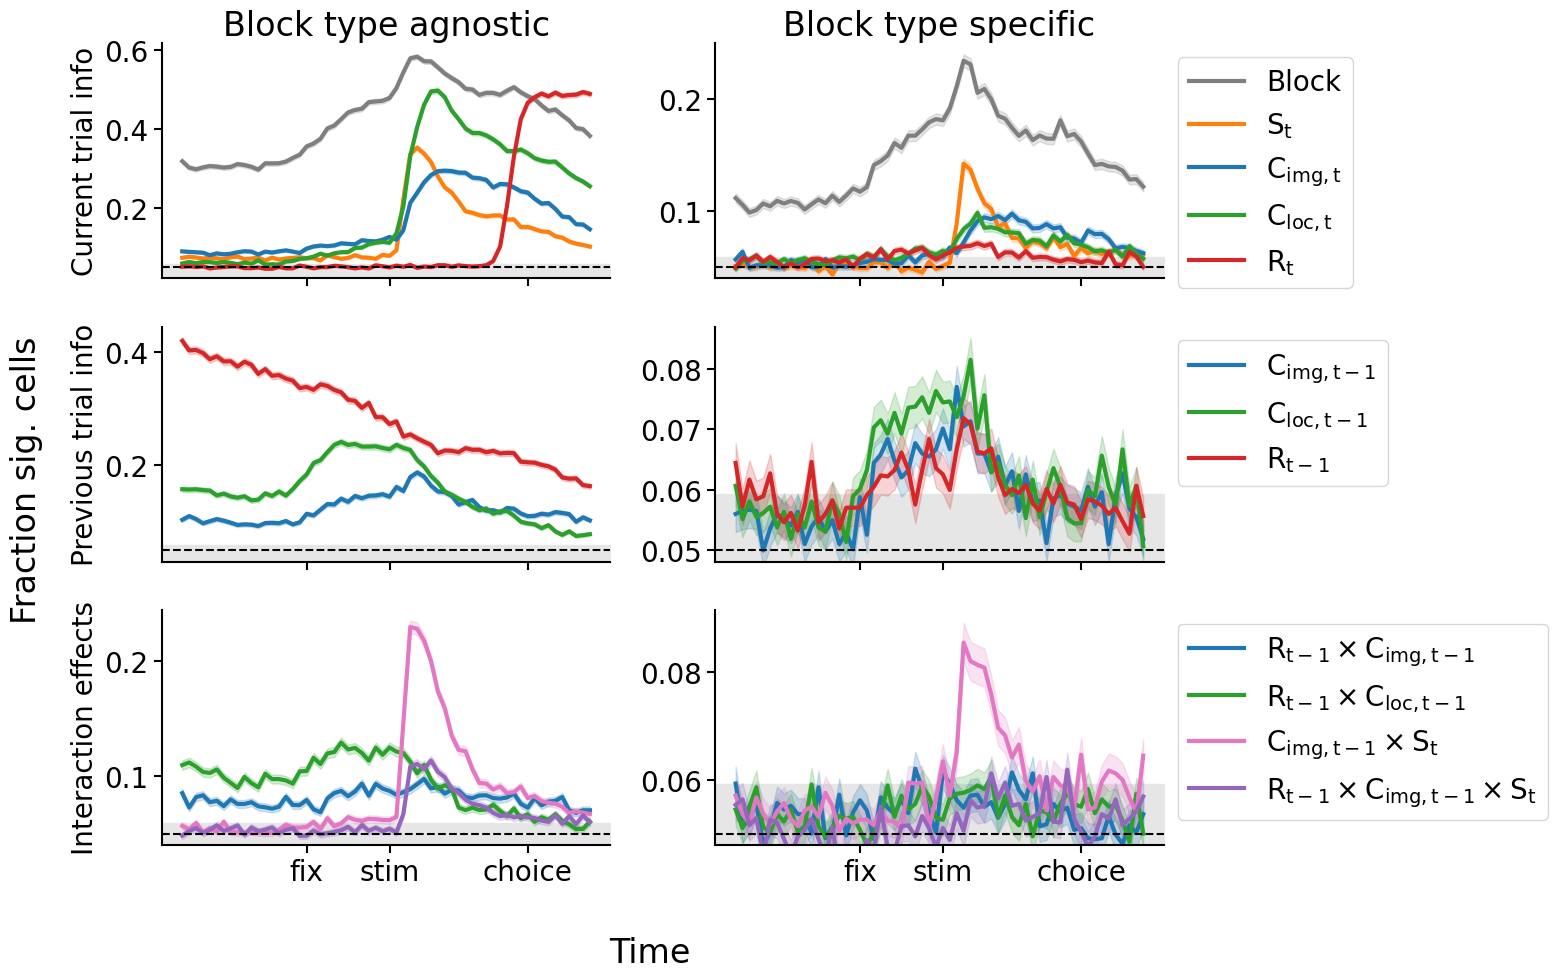

In [7]:
fig, axes = plt.subplots(3,2, sharex=True, figsize=(16, 10))

'''Current trial info'''

colors = ['tab:grey', 'tab:orange', 'tab:blue', 'tab:green', 'tab:red']

plot_mean_se(axes[0,0], xxx, all_sess_exp_var[...,2], color=colors[0], label='Block', axis=1)
plot_mean_se(axes[0,0], xxx, all_sess_exp_var[...,5], color=colors[1], label=r'$S_{t}$', axis=1)
plot_mean_se(axes[0,0], xxx, all_sess_exp_var[...,8], color=colors[2], label=r'$C_{img, t}$', axis=1)
plot_mean_se(axes[0,0], xxx, all_sess_exp_var[...,9], color=colors[3], label=r'$C_{loc, t}$', axis=1)
plot_mean_se(axes[0,0], xxx, all_sess_exp_var[...,11], color=colors[4], label=r'$R_{t}$', axis=1)


plot_mean_se(axes[0,1], xxx, all_sess_exp_var[...,1], color=colors[0], label='Block', axis=1)
plot_mean_se(axes[0,1], xxx, all_sess_exp_var[...,4], color=colors[1], label=r'$S_{t}$', axis=1)
plot_mean_se(axes[0,1], xxx, all_sess_exp_var[...,7], color=colors[2], label=r'$C_{img, t}$', axis=1)
plot_mean_se(axes[0,1], xxx, all_sess_exp_var[...,10], color=colors[3], label=r'$C_{loc, t}$', axis=1)
plot_mean_se(axes[0,1], xxx, all_sess_exp_var[...,13], color=colors[4], label=r'$R_{t}$', axis=1)

axes[0,0].set_title('Block type agnostic')
axes[0,1].set_title('Block type specific')
axes[0,0].set_ylabel('Current trial info')

# axes[0].ticklabel_format(style='sci', scilimits=(0,6), useMathText=True)
# axes[1].ticklabel_format(style='sci', scilimits=(0,6), useMathText=True)


axes[0,1].legend(bbox_to_anchor=(1., 1.))


'''Prev trial info'''

colors=['tab:blue', 'tab:green', 'tab:red']

plot_mean_se(axes[1,0], xxx, all_sess_exp_var[...,15], color=colors[0], label=r'$C_{img, t-1}$', axis=1)
plot_mean_se(axes[1,0], xxx, all_sess_exp_var[...,16], color=colors[1], label=r'$C_{loc, t-1}$', axis=1)
plot_mean_se(axes[1,0], xxx, all_sess_exp_var[...,18], color=colors[2], label=r'$R_{t-1}$', axis=1)


plot_mean_se(axes[1,1], xxx, all_sess_exp_var[...,14], color=colors[0], label=r'$C_{img, t-1}$', axis=1)
plot_mean_se(axes[1,1], xxx, all_sess_exp_var[...,17], color=colors[1], label=r'$C_{loc, t-1}$', axis=1)
plot_mean_se(axes[1,1], xxx, all_sess_exp_var[...,19], color=colors[2], label=r'$R_{t-1}$', axis=1)


axes[1,0].set_ylabel('Previous trial info')
axes[1,1].legend(bbox_to_anchor=(1., 1.))


'''Interaction effects'''

colors= ['tab:orange', 'tab:blue', 'tab:green', 'tab:pink', 'tab:purple']

# plot_mean_se(axes[2,0], xxx, all_sess_exp_var[...,29], color=colors[0], label=r'$R_{t-1}\times S_{t}$', axis=1)
plot_mean_se(axes[2,0], xxx, all_sess_exp_var[...,24], color=colors[1], 
             label=r'$R_{t-1}\times C_{img, t-1}$', axis=1)
plot_mean_se(axes[2,0], xxx, all_sess_exp_var[...,20], color=colors[2], 
             label=r'$R_{t-1}\times C_{loc, t-1}$', axis=1)
plot_mean_se(axes[2,0], xxx, all_sess_exp_var[...,25], color=colors[3], 
             label=r'$C_{img, t-1} \times S_{t}$', axis=1)
plot_mean_se(axes[2,0], xxx, all_sess_exp_var[...,30], color=colors[4], 
             label=r'$R_{t-1}\times C_{img, t-1} \times S_{t}$', axis=1)

# plot_mean_se(axes[2,1], xxx, all_sess_exp_var[...,28], color=colors[0], label=None, axis=1)
plot_mean_se(axes[2,1], xxx, all_sess_exp_var[...,23], color=colors[1], 
             label=r'$R_{t-1}\times C_{img, t-1}$', axis=1)
plot_mean_se(axes[2,1], xxx, all_sess_exp_var[...,21], color=colors[2], 
             label=r'$R_{t-1}\times C_{loc, t-1}$', axis=1)
plot_mean_se(axes[2,1], xxx, all_sess_exp_var[...,26], color=colors[3], 
             label=r'$C_{img, t-1} \times S_{t}$', axis=1)
plot_mean_se(axes[2,1], xxx, all_sess_exp_var[...,31], color=colors[4], 
             label=r'$R_{t-1}\times C_{img, t-1} \times S_{t}$', axis=1)

thresh = stats.binom.ppf(1-0.05/all_sess_exp_var.shape[0], all_sess_exp_var.shape[1], 0.05)\
                    /all_sess_exp_var.shape[1]

for a_row in axes:
    for a in a_row:
        a.axhline(0.05, ls='--', c='k')
        a.set_xticks([-600, 0, 1000], ['fix', 'stim', 'choice'])
        ylims = [0.05-(a.get_ylim()[1]-0.05)*0.05, a.get_ylim()[1]]
        a.set_ylim(ylims)
#         a.axhline(thresh, ls=':', c='k')
        xlims = a.get_xlim()
        a.fill_between(xlims, [0.0, 0.0], [thresh, thresh], color=[0.9, 0.9, 0.9], zorder=-1)
        a.set_xlim(xlims)
        


axes[2,0].set_ylabel('Interaction effects')
axes[2,1].legend(bbox_to_anchor=(1., 1.))

fig.supylabel('Fraction sig. cells')
fig.supxlabel('Time', x=0.42, y=0.01)



sns.despine()

fig.tight_layout()

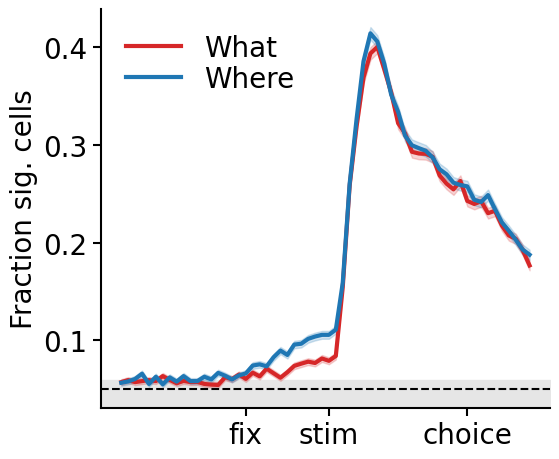

In [8]:
fig, axes = plt.subplots(1,1, sharex=True, figsize=(6, 5))

colors= ['tab:red', 'tab:blue']


plot_mean_se(axes, xxx, all_sess_contr_pvals[...,0], color=colors[0], label='What', axis=1)
plot_mean_se(axes, xxx, all_sess_contr_pvals[...,1], color=colors[1], label='Where', axis=1)

axes.legend(frameon=False, labelspacing=0.1)

axes.axhline(0.05, ls='--', c='k')
axes.set_xticks([-600, 0, 1000], ['fix', 'stim', 'choice'])
ylims = [0.05-(axes.get_ylim()[1]-0.05)*0.05, axes.get_ylim()[1]]
axes.set_ylim(ylims)
#         a.axhline(thresh, ls=':', c='k')
xlims = a.get_xlim()
axes.fill_between(xlims, [0.0, 0.0], [thresh, thresh], color=[0.9, 0.9, 0.9], zorder=-1)
axes.set_xlim(xlims)


axes.set_ylabel('Fraction sig. cells')
# axes.set_xlabel('Time')



sns.despine()

fig.tight_layout()


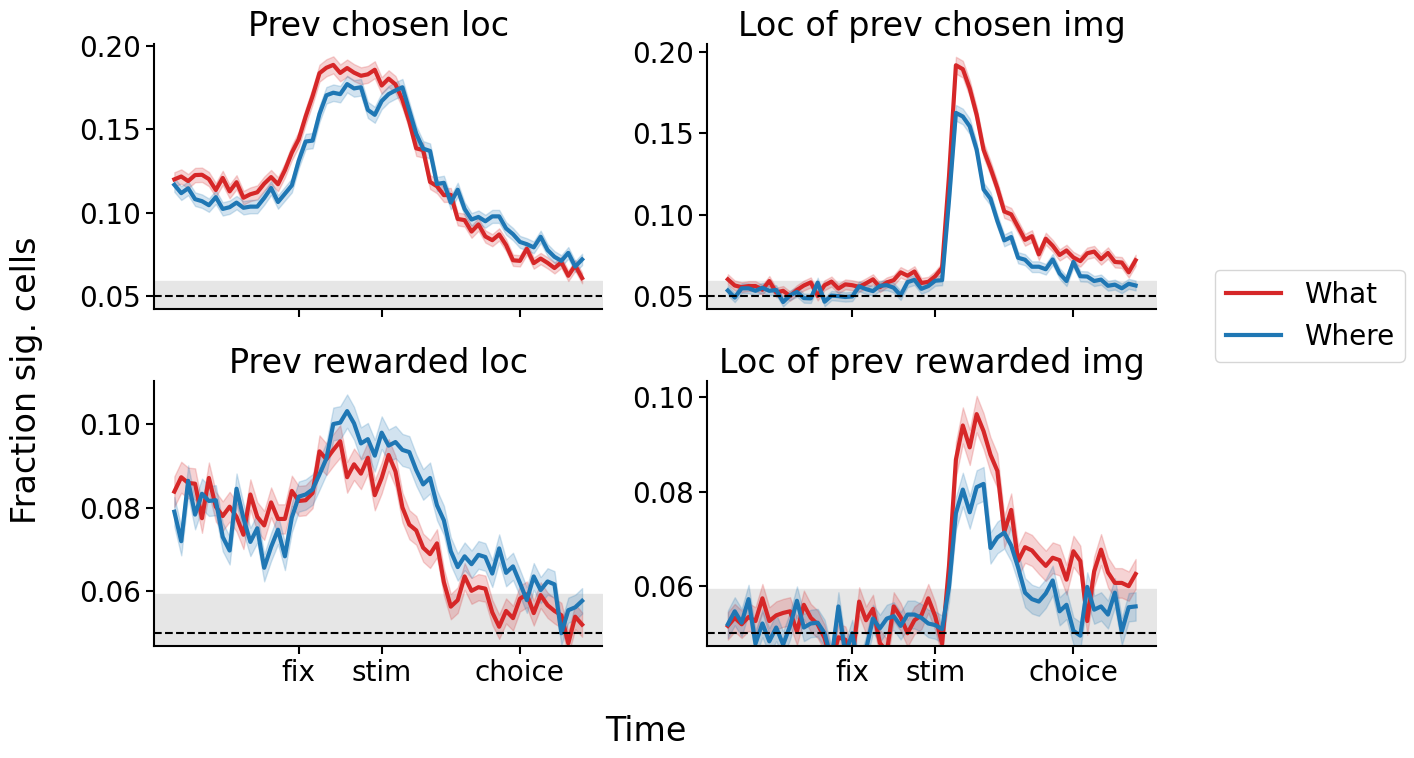

In [9]:
fig, axes = plt.subplots(2,2, sharex=True, figsize=(12, 8))

colors= ['tab:red', 'tab:blue']


plot_mean_se(axes[0,0], xxx, all_sess_contr_pvals[...,2], color=colors[0], label='What', axis=1)
plot_mean_se(axes[0,0], xxx, all_sess_contr_pvals[...,3], color=colors[1], label='Where', axis=1)
axes[0,0].set_title('Prev chosen loc')

plot_mean_se(axes[1,0], xxx, all_sess_contr_pvals[...,4], color=colors[0], label='What', axis=1)
plot_mean_se(axes[1,0], xxx, all_sess_contr_pvals[...,5], color=colors[1], label='Where', axis=1)
axes[1,0].set_title('Prev rewarded loc')

plot_mean_se(axes[0,1], xxx, all_sess_contr_pvals[...,6], color=colors[0], label='What', axis=1)
plot_mean_se(axes[0,1], xxx, all_sess_contr_pvals[...,7], color=colors[1], label='Where', axis=1)
axes[0,1].set_title('Loc of prev chosen img')

plot_mean_se(axes[1,1], xxx, all_sess_contr_pvals[...,8], color=colors[0], label='What', axis=1)
plot_mean_se(axes[1,1], xxx, all_sess_contr_pvals[...,9], color=colors[1], label='Where', axis=1)
axes[1,1].set_title('Loc of prev rewarded img')

fig.supylabel('Fraction sig. cells')
fig.supxlabel('Time', x=0.55, y=0.04)

for a_row in axes:
    for a in a_row:
        a.axhline(0.05, ls='--', c='k')
        a.set_xticks([-600, 0, 1000], ['fix', 'stim', 'choice'])
        ylims = [0.05-(a.get_ylim()[1]-0.05)*0.05, a.get_ylim()[1]]
        a.set_ylim(ylims)
#         a.axhline(thresh, ls=':', c='k')
        xlims = a.get_xlim()
        a.fill_between(xlims, [0.0, 0.0], [thresh, thresh], color=[0.9, 0.9, 0.9], zorder=-1)
        a.set_xlim(xlims)

fig.tight_layout()

axes[0,1].legend(bbox_to_anchor=(1.1, 0.2))
        
# axes[0,1].legend(loc='upper left', frameon=False, labelspacing=0.1)
        
sns.despine()




## Congruent coding of choice history

In [105]:
def plot_time_varying_correlation(xxx, yyy, ax, title, vlim=0.4, metric='corr'):        
    
    if metric=='cosine':
        sim = (xxx/np.linalg.norm(xxx, axis=-1, keepdims=True))@\
                    (yyy/np.linalg.norm(yyy, axis=-1, keepdims=True)).T
    if metric=='dot':
        sim = (xxx)@(yyy).T
    elif metric=='corr':
        sim = np.corrcoef(xxx, yyy)[:num_timesteps,num_timesteps:]
    elif metric=='cov':
        sim = np.cov(xxx, yyy)[:num_timesteps,num_timesteps:]
    elif metric=='spearman':
        sim = stats.spearmanr(xxx.T, yyy.T).statistic[:num_timesteps,num_timesteps:]
    
    
    if vlim is None:
        vlim = np.abs(sim).max()
    
    sns.heatmap(sim, 
                cmap='RdBu_r', vmin=-vlim, vmax=vlim, 
                ax=ax, square=True, cbar_kws={'shrink': 0.7})
    ax.axvline(50, ls=':', c='grey')
    ax.axhline(50, ls=':', c='grey')
    ax.axvline(30, ls=':', c='grey')
    ax.axhline(30, ls=':', c='grey')
    ax.axvline(18, ls=':', c='grey')
    ax.axhline(18, ls=':', c='grey')
    ax.set_title(title)
    ax.set_xticks([18, 30, 50], ['fix', 'stim', 'choice'], rotation=0)
    ax.set_yticks([], [])
    
    return sim


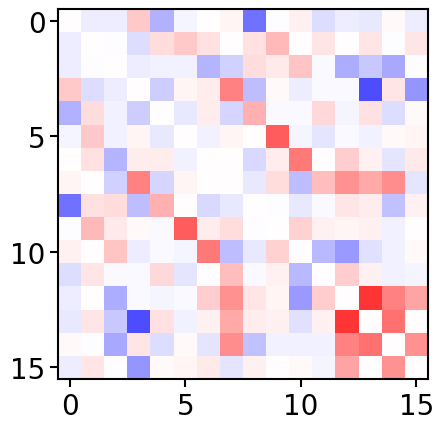

In [112]:
plt.imshow(np.corrcoef(all_sess_betas[:].mean(0)[:,[0,1,72,73,
                                                    74,75,
                                                    100,101,
                                                    102,103,
                                                    104,105,
                                                    130,131,
                                                    156,157]].T)-np.eye(16), 
           cmap='seismic', vmin=-0.8, vmax=0.8)


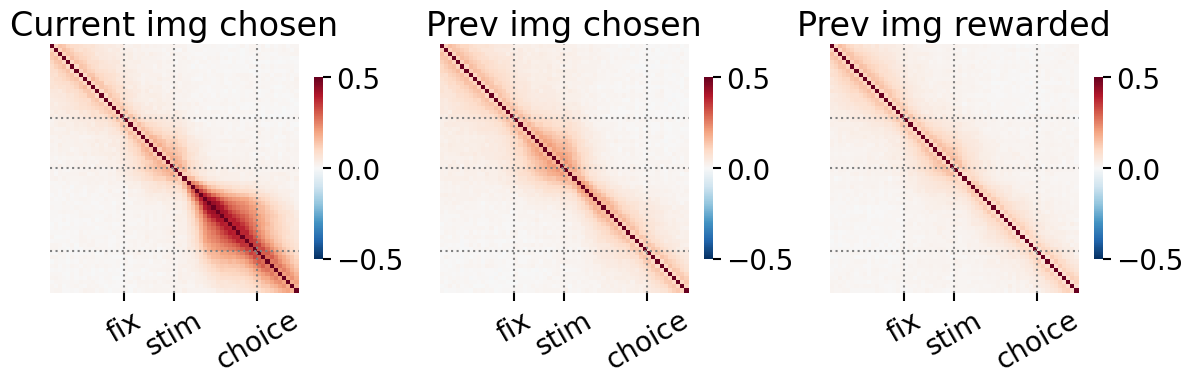

In [114]:
fig, axes = plt.subplots(1,3, figsize=(12, 4))

all_sims_img_curr = []
all_sims_img_cr = []
all_sims_img_wsls = []



for iii in range(24):
    
    curr_contrast = all_contrasts[iii,:][None,None]
    
    all_sims_img_curr.append(np.corrcoef(np.sum(all_sess_betas[...,48:71]*curr_contrast, -1), 
                                         np.sum(all_sess_betas[...,48:71]*curr_contrast, -1))[:num_timesteps,num_timesteps:])
    all_sims_img_cr.append(np.corrcoef(np.sum(all_sess_betas[...,76:99]*curr_contrast, -1), 
                                         np.sum(all_sess_betas[...,76:99]*curr_contrast, -1))[:num_timesteps,num_timesteps:])
    all_sims_img_wsls.append(np.corrcoef(np.sum(all_sess_betas[...,106:129]*curr_contrast, -1), 
                                         np.sum(all_sess_betas[...,106:129]*curr_contrast, -1))[:num_timesteps,num_timesteps:])

vlim=0.5
sns.heatmap(np.stack(all_sims_img_curr).mean(0), cmap='RdBu_r', vmin=-vlim, vmax=vlim, 
            ax=axes[0], square=True, cbar_kws={'shrink': 0.6})
axes[0].set_title('Current img chosen')

vlim=0.5
sns.heatmap(np.stack(all_sims_img_cr).mean(0), cmap='RdBu_r', vmin=-vlim, vmax=vlim, 
            ax=axes[1], square=True, cbar_kws={'shrink': 0.6})
axes[1].set_title('Prev img chosen')

vlim=0.5
sns.heatmap(np.stack(all_sims_img_wsls).mean(0), cmap='RdBu_r', vmin=-vlim, vmax=vlim, 
            ax=axes[2], square=True, cbar_kws={'shrink': 0.6})
axes[2].set_title('Prev img rewarded')

for ax in axes:
    ax.axvline(50, ls=':', c='grey')
    ax.axhline(50, ls=':', c='grey')
    ax.axvline(30, ls=':', c='grey')
    ax.axhline(30, ls=':', c='grey')
    ax.axvline(18, ls=':', c='grey')
    ax.axhline(18, ls=':', c='grey')
    ax.set_xticks([18, 30, 50], ['fix', 'stim', 'choice'], rotation=30)
    ax.set_yticks([], [])

fig.tight_layout()


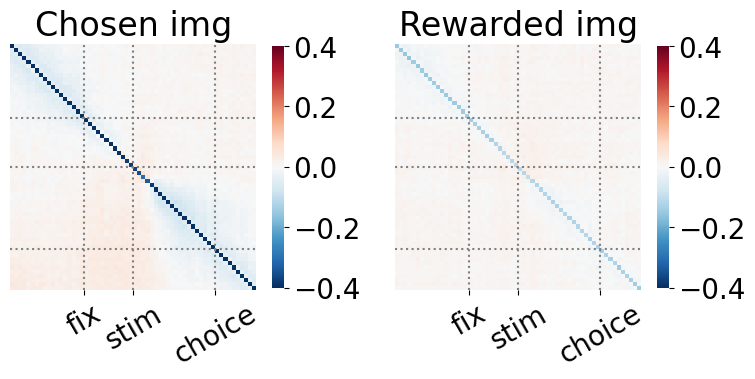

In [13]:
fig, axes = plt.subplots(1,2, figsize=(8, 4))

all_sims_img_cr = []
all_sims_img_wsls = []

for idx_sess in range(len(all_sess_regression_info['betas'])):
    curr_sess_betas = all_sess_regression_info['betas'][idx_sess]
    for iii in range(24):
        curr_contrast = all_contrasts[iii,:][None,None]
        all_sims_img_cr.append(np.corrcoef(
                np.sum(curr_sess_betas[...,48:71]*curr_contrast, -1), 
                np.sum(curr_sess_betas[...,76:99]*curr_contrast, -1))[:num_timesteps,num_timesteps:])
        all_sims_img_wsls.append(np.corrcoef(
                np.sum(curr_sess_betas[...,48:71]*curr_contrast, -1), 
                np.sum(curr_sess_betas[...,106:129]*curr_contrast, -1))[:num_timesteps,num_timesteps:])

vlim=0.4
sns.heatmap(np.stack(all_sims_img_cr).mean(0), cmap='RdBu_r', vmin=-vlim, vmax=vlim, 
            ax=axes[0], square=True, cbar_kws={'shrink': 0.8})
axes[0].set_title('Chosen img')

vlim=0.4
sns.heatmap(np.stack(all_sims_img_wsls).mean(0), cmap='RdBu_r', vmin=-vlim, vmax=vlim, 
            ax=axes[1], square=True, cbar_kws={'shrink': 0.8})
axes[1].set_title('Rewarded img')

for ax in axes:
    ax.axvline(50, ls=':', c='grey')
    ax.axhline(50, ls=':', c='grey')
    ax.axvline(30, ls=':', c='grey')
    ax.axhline(30, ls=':', c='grey')
    ax.axvline(18, ls=':', c='grey')
    ax.axhline(18, ls=':', c='grey')
    ax.set_xticks([18, 30, 50], ['fix', 'stim', 'choice'], rotation=30)
    ax.set_yticks([], [])

fig.tight_layout()


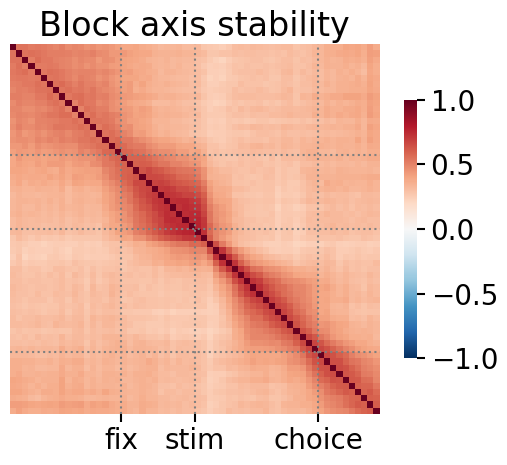

In [143]:
fig, axes = plt.subplots(1,1)

plot_time_varying_correlation(all_sess_betas[...,1],all_sess_betas[...,1], 
                              axes, title='Block axis stability', vlim=1);

In [13]:
def p_to_asterisks(pvalue):
    if pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

def plot_pair_regressions(ax, x1, y1, x2, y2, axis_lims, xlabel, labels=[None, None]):
    
    xlims = max([np.max(np.abs(x1)), np.max(np.abs(x2))])*1.1
    ax.set_xlim([-xlims, xlims])
    ylims = max([np.max(np.abs(y1)), np.max(np.abs(y2))])*1.1
    ax.set_ylim([-ylims, ylims])

    sns.regplot(x=x1, y=y1, truncate=False, color='tab:red', scatter=False, label=labels[0], ax=ax)
    sns.regplot(x=x2, y=y2, truncate=False, color='tab:blue', scatter=False, label=labels[1], ax=ax)
    
    sns.scatterplot(x=x1, y=y1, color='tab:red', ax=ax, alpha=0.2, legend=False)
    sns.scatterplot(x=x2, y=y2, color='tab:blue', ax=ax, alpha=0.2, legend=False)
    
    r1 = stats.pearsonr(x1, y1)
    r2 = stats.pearsonr(x2, y2)
    
    zdr = (np.arctanh(r1.statistic)-np.arctanh(r2.statistic))\
                /np.sqrt(1/(x1.shape[0]-3)+1/(x2.shape[0]-3))
    
    ax.text(xlims*0.5, -ylims*0.5, f"R={np.round(r1.statistic, 2)} {p_to_asterisks(r1.pvalue)}", color='tab:red', fontsize=16)
    ax.text(xlims*0.5, -ylims*0.7, f"R={np.round(r2.statistic, 2)} {p_to_asterisks(r2.pvalue)}", color='tab:blue', fontsize=16)
    ax.text(xlims*0.5, -ylims*0.9, 
            f"$\\Delta R$={np.round(r1.statistic-r2.statistic, 2)} {p_to_asterisks(1-norm.cdf(np.abs(zdr)))}", 
            color='tab:purple', fontsize=16)
    
    ax.set_xlabel(xlabel)
    
    
    
    

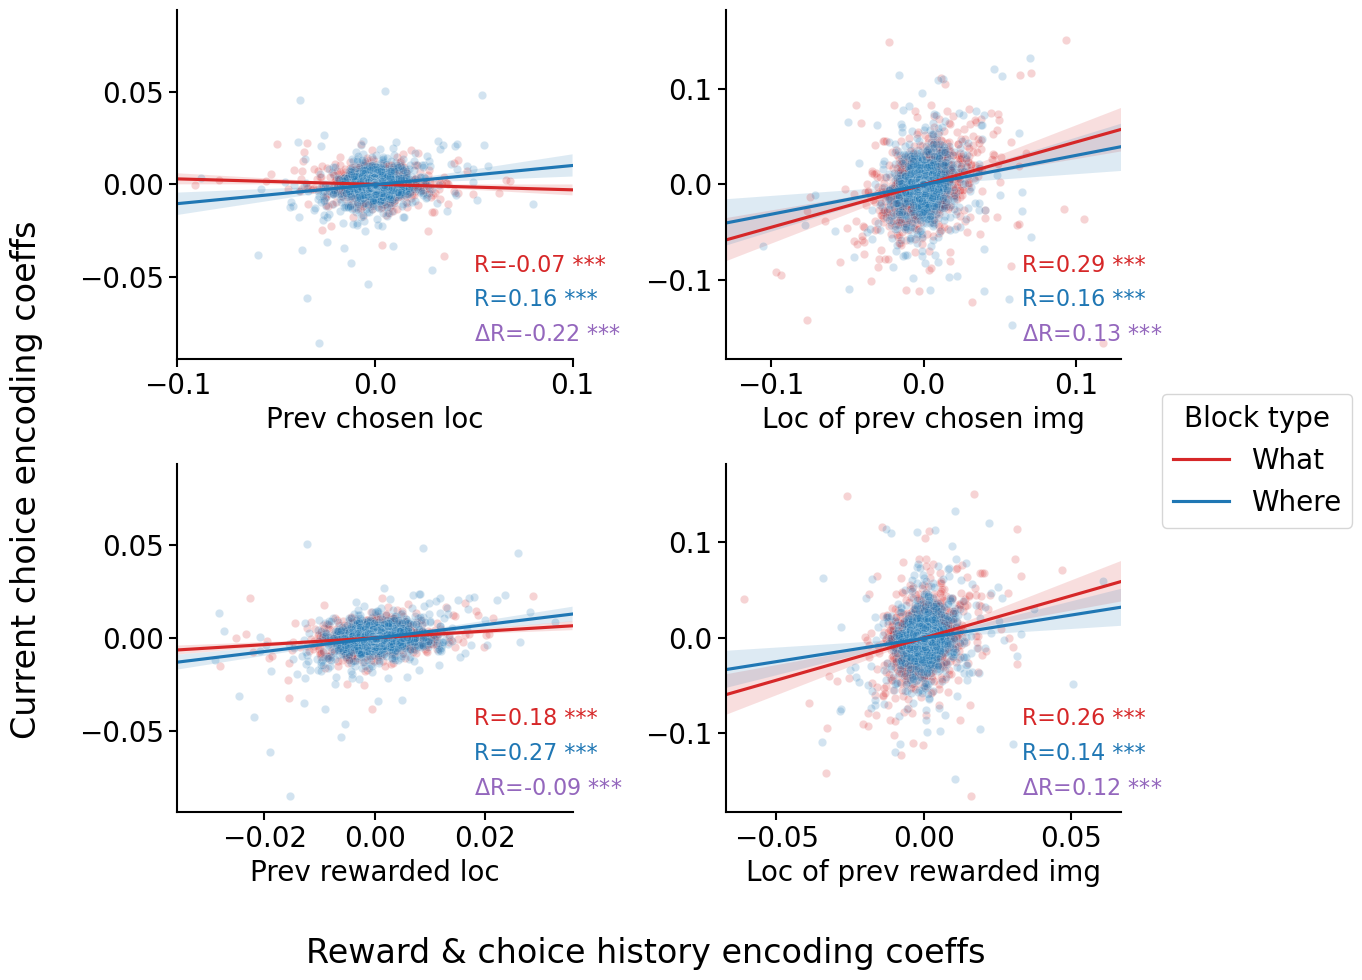

In [115]:
fig, axes = plt.subplots(2,2, figsize=(12,10))

plot_pair_regressions(axes[0,0], axis_lims=[-0.1, 0.1], xlabel='Prev chosen loc',
                      y1=(all_sess_betas[...,72]+all_sess_betas[...,73])[20:30].mean(0),
                      x1=(all_sess_betas[...,100]+all_sess_betas[...,101])[20:30].mean(0),
                      y2=(all_sess_betas[...,72]-all_sess_betas[...,73])[20:30].mean(0),
                      x2=(all_sess_betas[...,100]-all_sess_betas[...,101])[20:30].mean(0))

plot_pair_regressions(axes[1,0], axis_lims=[-0.1, 0.1], xlabel='Prev rewarded loc',
                      y1=(all_sess_betas[...,72]+all_sess_betas[...,73])[20:30].mean(0), 
                      x1=(all_sess_betas[...,104]+all_sess_betas[...,105])[20:30].mean(0),
                      y2=(all_sess_betas[...,72]-all_sess_betas[...,73])[20:30].mean(0),
                      x2=(all_sess_betas[...,104]-all_sess_betas[...,105])[20:30].mean(0))

plot_pair_regressions(axes[0,1], axis_lims=[-0.1, 0.1], xlabel='Loc of prev chosen img',
                      y1=(all_sess_betas[...,72]+all_sess_betas[...,73])[32:35].mean(0), 
                      x1=(all_sess_betas[...,130]+all_sess_betas[...,131])[32:35].mean(0),
                      y2=(all_sess_betas[...,72]-all_sess_betas[...,73])[32:35].mean(0),
                      x2=(all_sess_betas[...,130]-all_sess_betas[...,131])[32:35].mean(0))

plot_pair_regressions(axes[1,1], axis_lims=[-0.1, 0.1], xlabel='Loc of prev rewarded img',
                      y1=(all_sess_betas[...,72]+all_sess_betas[...,73])[32:35].mean(0), 
                      x1=(all_sess_betas[...,156]+all_sess_betas[...,157])[33:36].mean(0),
                      y2=(all_sess_betas[...,72]-all_sess_betas[...,73])[32:35].mean(0),
                      x2=(all_sess_betas[...,156]-all_sess_betas[...,157])[33:36].mean(0),
                     labels=['What', 'Where'])

fig.legend(bbox_to_anchor=(1.15,0.6), title='Block type')
fig.supxlabel('Reward & choice history encoding coeffs', x=0.55)
fig.supylabel('Current choice encoding coeffs')

sns.despine()
fig.tight_layout()

plt.savefig(os.path.join(figure_data_dir, "subspace_alignment.pdf"), bbox_inches='tight')

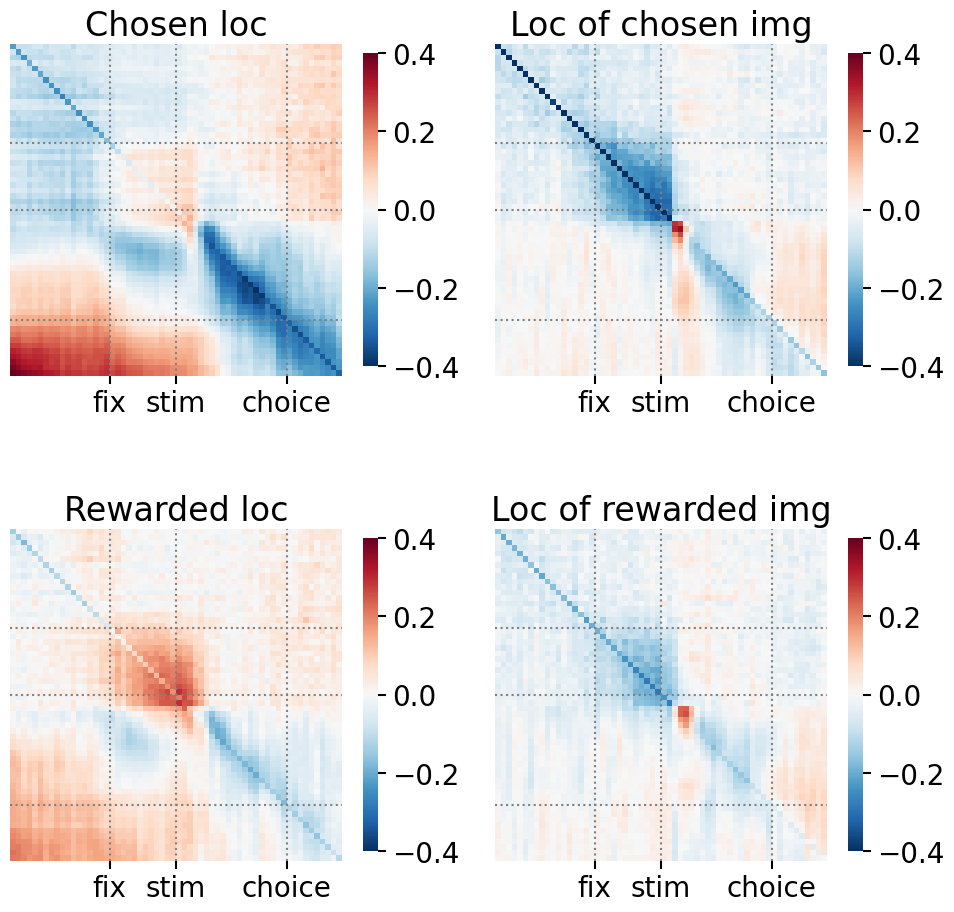

In [108]:
fig, axes = plt.subplots(2,2,figsize=(10,10))

sims_overall = []

sims_overall.append(plot_time_varying_correlation(all_sess_betas[...,72], all_sess_betas[...,100], 
                              axes[0,0], title='Chosen loc', metric='cosine'))
sims_overall.append(plot_time_varying_correlation(all_sess_betas[...,72], all_sess_betas[...,130], 
                              axes[0,1], title='Loc of chosen img', metric='cosine'))

sims_overall.append(plot_time_varying_correlation(all_sess_betas[...,72], all_sess_betas[...,104], 
                              axes[1,0], title='Rewarded loc', metric='cosine'))
sims_overall.append(plot_time_varying_correlation(all_sess_betas[...,72], all_sess_betas[...,156], 
                              axes[1,1], title='Loc of rewarded img', metric='cosine'))

fig.tight_layout()


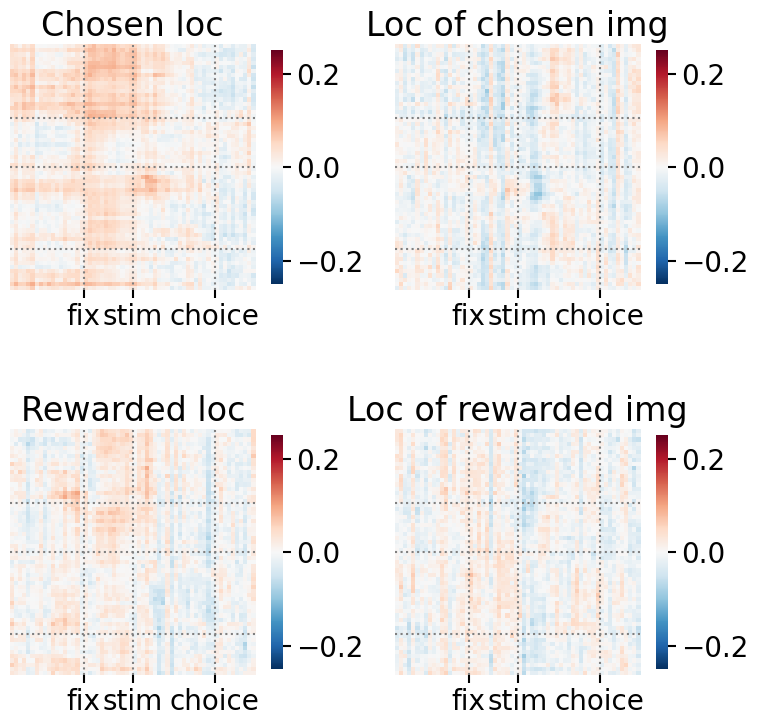

In [420]:
fig, axes = plt.subplots(2,2, figsize=(8,8))

sims_overall = []

sims_overall.append(plot_time_varying_correlation(all_sess_betas[...,1], all_sess_betas[...,100], 
                              axes[0,0], title='Chosen loc', vlim=0.25))
sims_overall.append(plot_time_varying_correlation(all_sess_betas[...,1], all_sess_betas[...,130], 
                              axes[0,1], title='Loc of chosen img', vlim=0.25))

sims_overall.append(plot_time_varying_correlation(all_sess_betas[...,1], all_sess_betas[...,104], 
                              axes[1,0], title='Rewarded loc', vlim=0.25))
sims_overall.append(plot_time_varying_correlation(all_sess_betas[...,1], all_sess_betas[...,156], 
                              axes[1,1], title='Loc of rewarded img', vlim=0.25))

fig.tight_layout()


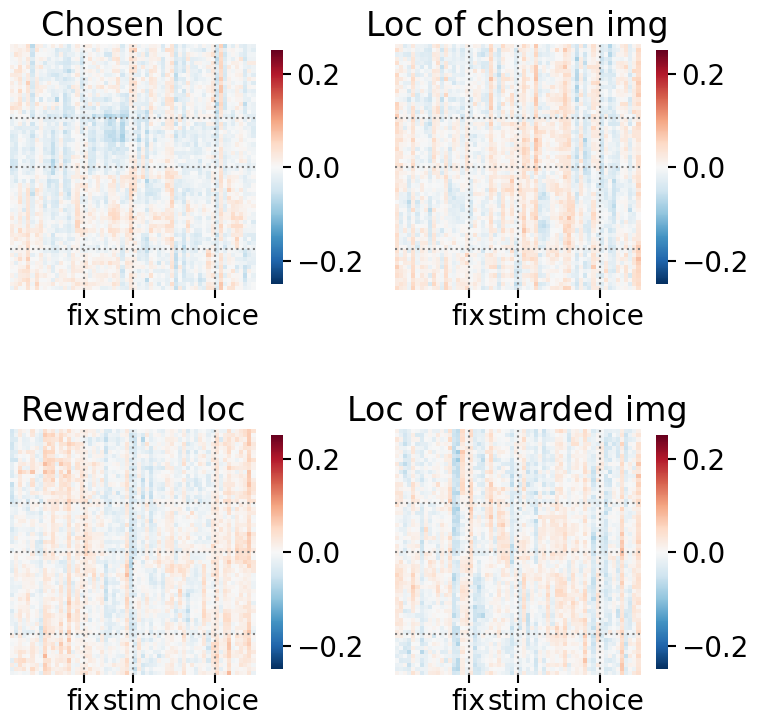

In [421]:
fig, axes = plt.subplots(2,2, figsize=(8,8))

sims_overall = []

sims_overall.append(plot_time_varying_correlation(all_sess_betas[...,1], all_sess_betas[...,101], 
                              axes[0,0], title='Chosen loc', vlim=0.25))
sims_overall.append(plot_time_varying_correlation(all_sess_betas[...,1], all_sess_betas[...,131], 
                              axes[0,1], title='Loc of chosen img', vlim=0.25))

sims_overall.append(plot_time_varying_correlation(all_sess_betas[...,1], all_sess_betas[...,105], 
                              axes[1,0], title='Rewarded loc', vlim=0.25))
sims_overall.append(plot_time_varying_correlation(all_sess_betas[...,1], all_sess_betas[...,157], 
                              axes[1,1], title='Loc of rewarded img', vlim=0.25))

fig.tight_layout()


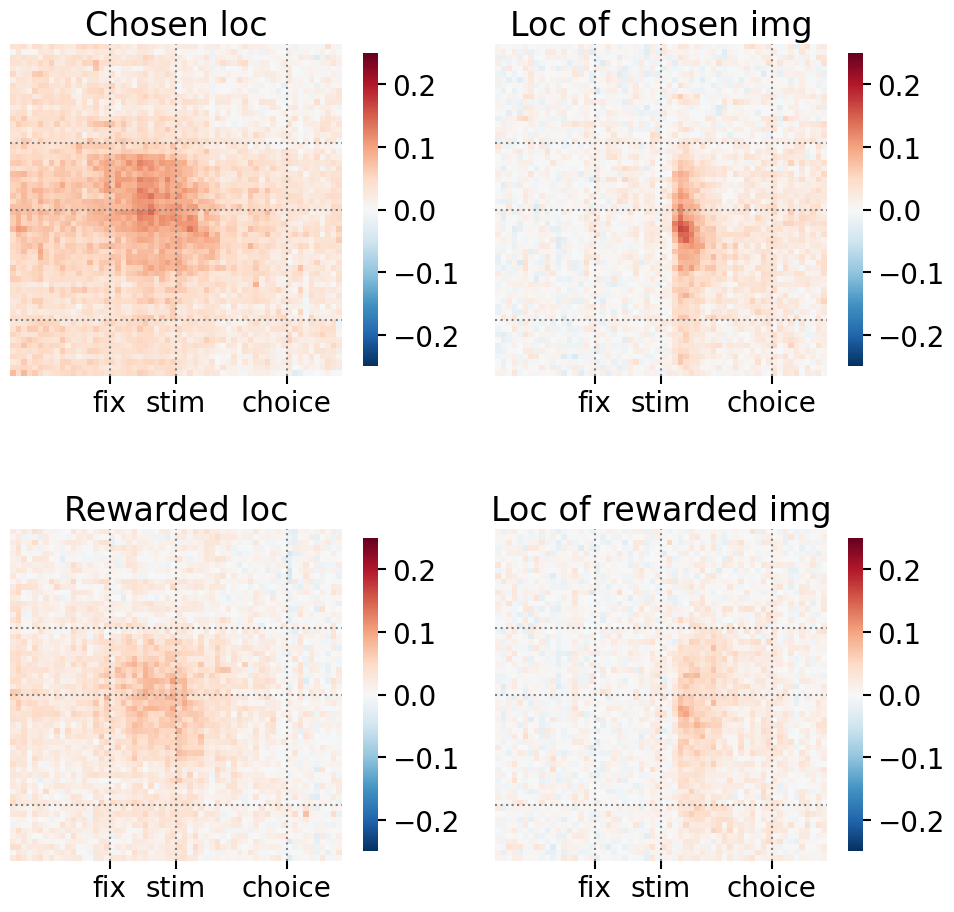

In [422]:
fig, axes = plt.subplots(2,2, figsize=(10,10))

sims_overall = []

sims_overall.append(plot_time_varying_correlation(all_sess_exp_var[...,1], all_sess_exp_var[...,16], 
                              axes[0,0], title='Chosen loc', vlim=0.25, metric='corr'))
sims_overall.append(plot_time_varying_correlation(all_sess_exp_var[...,1], all_sess_exp_var[...,25], 
                              axes[0,1], title='Loc of chosen img', vlim=0.25, metric='corr'))

sims_overall.append(plot_time_varying_correlation(all_sess_exp_var[...,1], all_sess_exp_var[...,20], 
                              axes[1,0], title='Rewarded loc', vlim=0.25, metric='corr'))
sims_overall.append(plot_time_varying_correlation(all_sess_exp_var[...,1], all_sess_exp_var[...,30], 
                              axes[1,1], title='Loc of rewarded img', vlim=0.25, metric='corr'))

fig.tight_layout()


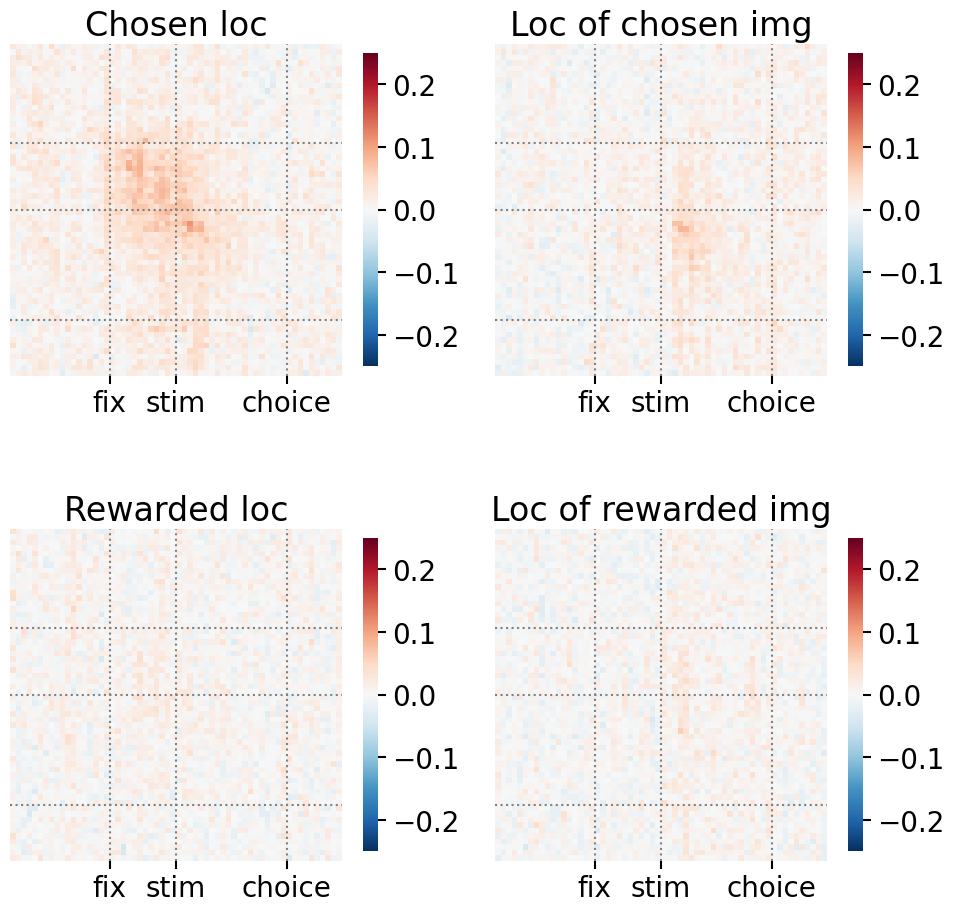

In [423]:
fig, axes = plt.subplots(2,2, figsize=(10,10))

sims_overall = []

sims_overall.append(plot_time_varying_correlation(all_sess_exp_var[...,1], all_sess_exp_var[...,17], 
                              axes[0,0], title='Chosen loc', vlim=0.25, metric='corr'))
sims_overall.append(plot_time_varying_correlation(all_sess_exp_var[...,1], all_sess_exp_var[...,26], 
                              axes[0,1], title='Loc of chosen img', vlim=0.25, metric='corr'))

sims_overall.append(plot_time_varying_correlation(all_sess_exp_var[...,1], all_sess_exp_var[...,21], 
                              axes[1,0], title='Rewarded loc', vlim=0.25, metric='corr'))
sims_overall.append(plot_time_varying_correlation(all_sess_exp_var[...,1], all_sess_exp_var[...,31], 
                              axes[1,1], title='Loc of rewarded img', vlim=0.25, metric='corr'))

fig.tight_layout()


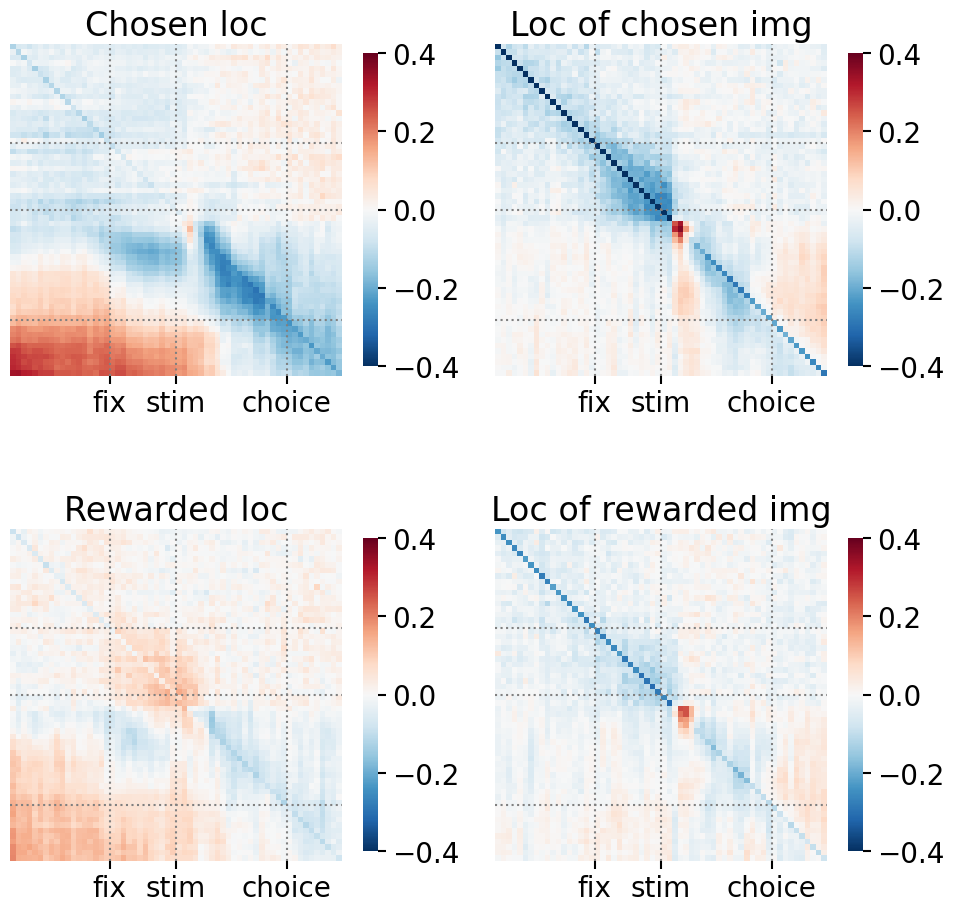

In [109]:
fig, axes = plt.subplots(2,2, figsize=(10,10))

sims_what = []

sims_what.append(plot_time_varying_correlation(all_sess_betas[...,72]+all_sess_betas[...,73], 
                              all_sess_betas[...,100]+all_sess_betas[...,101], 
                              axes[0,0], title='Chosen loc', metric='cosine'))
sims_what.append(plot_time_varying_correlation(all_sess_betas[...,72]+all_sess_betas[...,73], 
                              all_sess_betas[...,130]+all_sess_betas[...,131], 
                              axes[0,1], title='Loc of chosen img', metric='cosine'))

sims_what.append(plot_time_varying_correlation(all_sess_betas[...,72]+all_sess_betas[...,73], 
                              all_sess_betas[...,104]+all_sess_betas[...,105], 
                              axes[1,0], title='Rewarded loc', metric='cosine'))
sims_what.append(plot_time_varying_correlation(all_sess_betas[...,72]+all_sess_betas[...,73], 
                              all_sess_betas[...,156]+all_sess_betas[...,157], 
                              axes[1,1], title='Loc of rewarded img', metric='cosine'))

fig.tight_layout()

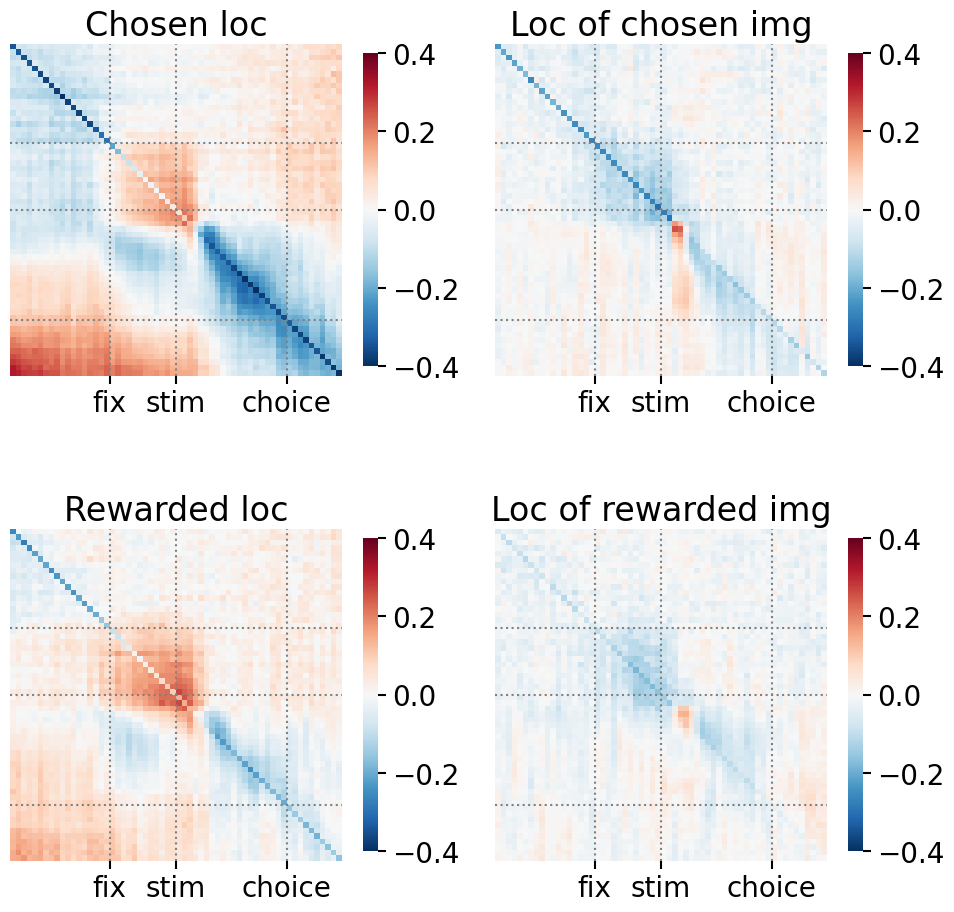

In [110]:
fig, axes = plt.subplots(2,2, figsize=(10, 10))


sims_where = []

sims_where.append(plot_time_varying_correlation(all_sess_betas[...,72]-all_sess_betas[...,73], 
                              all_sess_betas[...,100]-all_sess_betas[...,101], 
                              axes[0,0], title='Chosen loc', metric='cosine'))
sims_where.append(plot_time_varying_correlation(all_sess_betas[...,72]-all_sess_betas[...,73], 
                              all_sess_betas[...,130]-all_sess_betas[...,131], 
                              axes[0,1], title='Loc of chosen img', metric='cosine'))

sims_where.append(plot_time_varying_correlation(all_sess_betas[...,72]-all_sess_betas[...,73], 
                              all_sess_betas[...,104]-all_sess_betas[...,105], 
                              axes[1,0], title='Rewarded loc', metric='cosine'))
sims_where.append(plot_time_varying_correlation(all_sess_betas[...,72]-all_sess_betas[...,73], 
                              all_sess_betas[...,156]-all_sess_betas[...,157], 
                              axes[1,1], title='Loc of rewarded img', metric='cosine'))

fig.tight_layout()

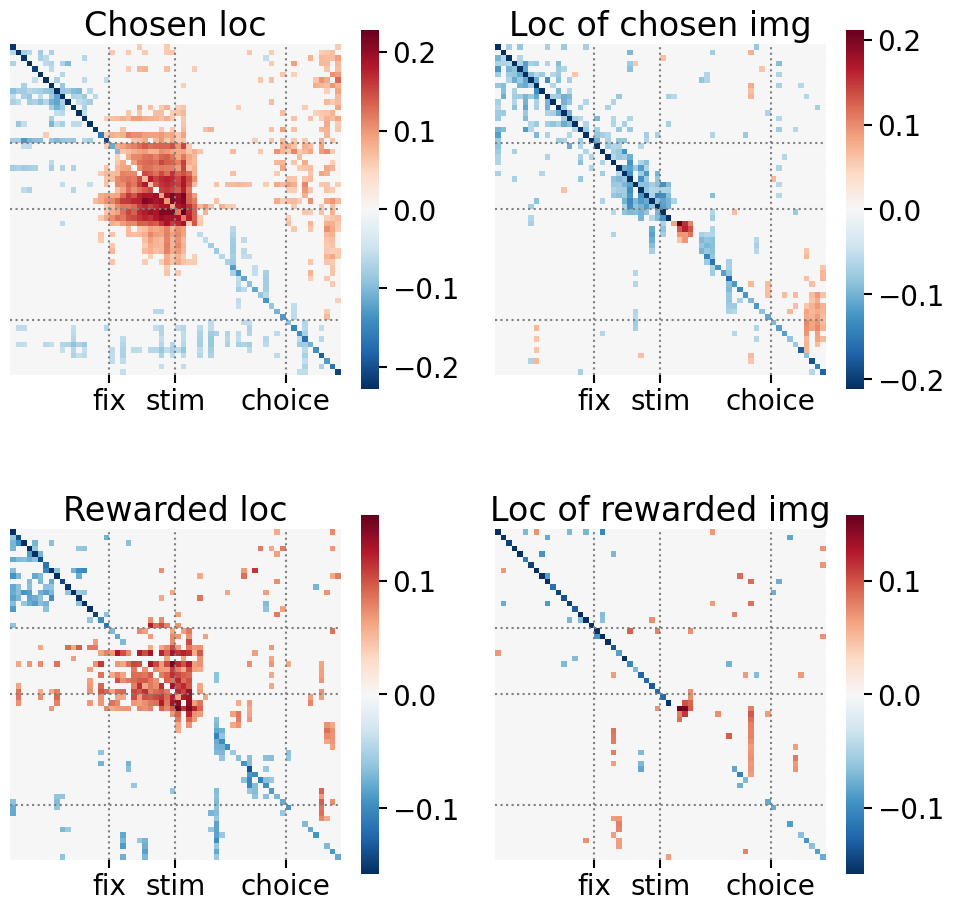

In [111]:
fig, axes = plt.subplots(2,2, figsize=(10,10))

ylabel_names = [['Chosen loc', 'Loc of chosen img'],
                ['Rewarded loc', 'Loc of rewarded img']]



n_neurons = all_sess_betas.shape[1]

for i in range(2):
    for j in range(2):
        ax = axes[i,j]
        if j==1:
            sims_diff = sims_what[i*2+j]-sims_where[i*2+j]
            sims_diff_z = (np.arctanh(sims_what[i*2+j])-np.arctanh(sims_where[i*2+j]))/np.sqrt(2/(n_neurons-3))
            sims_diff_p = 1-norm.cdf(np.abs(sims_diff_z))
        else:
            sims_diff = sims_where[i*2+j]-sims_what[i*2+j]
            sims_diff_z = (np.arctanh(sims_where[i*2+j])-np.arctanh(sims_what[i*2+j]))/np.sqrt(2/(n_neurons-3))
            sims_diff_p = 1-norm.cdf(np.abs(sims_diff_z))
            
        _,adj_p,_,_ = multipletests(sims_diff_p.reshape(60**2), method='fdr_by')
        adj_p = adj_p.reshape((60,60))
        
        vlim=np.max(sims_diff)
        
        sns.heatmap(sims_diff*(adj_p<0.05), 
                    cmap='RdBu_r', vmin=-vlim, vmax=vlim, 
                    ax=ax, square=True, cbar_kws={'shrink': 0.8})
        ax.axvline(50, ls=':', c='grey')
        ax.axhline(50, ls=':', c='grey')
        ax.axvline(30, ls=':', c='grey')
        ax.axhline(30, ls=':', c='grey')
        ax.axvline(18, ls=':', c='grey')
        ax.axhline(18, ls=':', c='grey')
        ax.set_title(ylabel_names[i][j])
        ax.set_xticks([18, 30, 50], ['fix', 'stim', 'choice'], rotation=0)
        ax.set_yticks([], [])

fig.tight_layout()

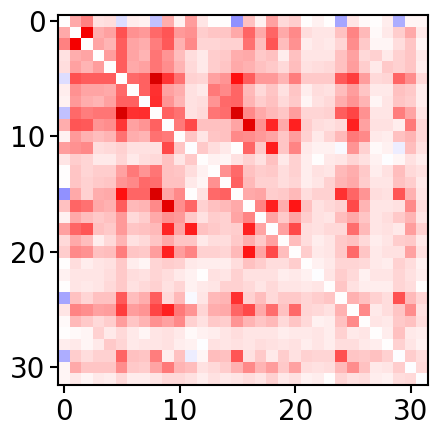

In [112]:
plt.imshow(stats.spearmanr(all_sess_exp_var.mean(0)).statistic-np.eye(32), vmin=-1, vmax=1, cmap='seismic')

## State space representation of choice and history

In [7]:
curr_contrast = all_contrasts[16,:][None,None]

curr_sess_betas = all_sess_regression_info['betas'][2]

u1, s1, vh1 = np.linalg.svd(np.sum(curr_sess_betas[...,48:71]*curr_contrast, -1), full_matrices=False)
u2, s2, vh2 = np.linalg.svd(np.sum(curr_sess_betas[...,76:99]*curr_contrast, -1), full_matrices=False)
u3, s3, vh3 = np.linalg.svd(np.sum(curr_sess_betas[...,106:129]*curr_contrast, -1), full_matrices=False)



In [143]:
def get_choice_history_state_space(all_sess_neural_data, all_sess_betas, all_sess_task_info,
                                    ch_axis_func, hist_axis_func, 
                                    curr_ch_func, prev_ch_func, 
                                    prev_rwd_func, block_type_func, 
                                    block_type_to_plot, is_wsls,
                                    sep_by_block=False):
    
    '''
    1. pca var explained plot
    2. coeff correlation plot
    3. state space plot
    '''

    results_dict = {
        'exp_vars': None,
        'all_axes': None,
        'all_proj': None,
        'proj_cond_avg': None,
        'proj_corrs': None,
    }
    
    num_sess = len(all_sess_betas)
    

    
    num_blocks = 24
    
    all_sess_proj_ch = np.zeros((num_sess, 2, 2, 2, 60)) 
    all_sess_proj_hist = np.zeros((num_sess, 2, 2, 2, 60)) 
    
    # num_curr_ch (2) X num_prev_ch (2) X num_rwd (2) X timesteps   
    
    all_axes_ch = []
    all_axes_hist = []
    
    all_proj_ch = []
    all_proj_hist = []

    all_exp_vars_ch = []
    all_exp_vars_hist = []
    
    for idx_sess in tqdm.tqdm(range(num_sess)):
        
        # center the neural data to get rid of effect of mean firing rates in projections
        centered_neural_data = \
            (all_sess_neural_data[idx_sess]-all_sess_neural_data[idx_sess].mean(0)).transpose((0,2,1))
                
        if not sep_by_block:
            # svd on curr choice and history axes
            u1, s1, vh1 = np.linalg.svd(ch_axis_func(all_sess_betas[idx_sess]), full_matrices=False)
            u2, s2, vh2 = np.linalg.svd(hist_axis_func(all_sess_betas[idx_sess]), full_matrices=False)

            all_exp_vars_ch.append(s1**2/(s1**2).sum())
            all_exp_vars_hist.append(s2**2/(s2**2).sum())

            vh1 *= np.sign((u1[:,0]).sum())
            vh2 *= np.sign((u2[:,0]).sum())
            
            all_axes_ch.append(vh1[0])
            all_axes_hist.append(vh2[0])

            axis1 = vh1[0]
            axis2 = vh2[0]-(vh1[0]*vh2[0]).sum()*vh1[0]
            axis2 /= np.sqrt((axis2**2).sum())
            
            
            # load trial information (current trial choice, prev trial choice, prev trial reward, block type)
            curr_sess_curr_ch = curr_ch_func(all_sess_task_info[idx_sess])
            curr_sess_prev_ch = prev_ch_func(all_sess_task_info[idx_sess])
            curr_sess_prev_rwd = prev_rwd_func(all_sess_task_info[idx_sess])
            curr_sess_block_type = block_type_func(all_sess_task_info[idx_sess]).astype(int)
            
            valid_trial_mask = all_sess_task_info[idx_sess][1:,7]<=24
            
            # select only trials with the current block
            curr_sess_curr_ch = curr_sess_curr_ch[valid_trial_mask&
                                                  (curr_sess_block_type==block_type_to_plot)].astype(int)
            curr_sess_prev_ch = curr_sess_prev_ch[valid_trial_mask&
                                                  (curr_sess_block_type==block_type_to_plot)].astype(int)
            curr_sess_prev_rwd = curr_sess_prev_rwd[valid_trial_mask&
                                                  (curr_sess_block_type==block_type_to_plot)].astype(int)

            curr_sess_neural_data = centered_neural_data[1:][valid_trial_mask&
                                                  (curr_sess_block_type==block_type_to_plot)]
            
            # project onto svd axes (note that they are not necessarily orthogonal)
            proj_ch = (curr_sess_neural_data*axis1).sum(-1) # num_trials-1 X num_timestep
            proj_hist = (curr_sess_neural_data*axis2).sum(-1) # num_trials-1 X num_timestep
                
        else:
            curr_sess_curr_ch = []
            curr_sess_prev_ch = []
            curr_sess_prev_rwd = []
            
            proj_ch = []
            proj_hist = []

            blocks_to_plot = np.arange(12) if block_type_to_plot==1 else np.arange(12,24)
            
            for idx_block in list(blocks_to_plot):
                
                # svd on the block-specific stim axes
                curr_contrast = all_contrasts[idx_block,:][None,None]
                u1, s1, vh1 = np.linalg.svd(ch_axis_func(all_sess_betas[idx_sess], curr_contrast), 
                                            full_matrices=False)
                u2, s2, vh2 = np.linalg.svd(hist_axis_func(all_sess_betas[idx_sess], curr_contrast), 
                                            full_matrices=False)
                
                vh1 *= np.sign((u1[:,0]).sum())
                vh2 *= np.sign((u2[:,0]).sum())
                
                all_axes_ch.append(vh1[0])
                all_axes_hist.append(vh2[0])

                axis1 = vh1[0]
                axis2 = vh2[0]-(vh1[0]*vh2[0]).sum()*vh1[0]
                axis2 /= np.sqrt((axis2**2).sum())
                
                
                # load trial info
                curr_block_curr_ch = curr_ch_func(all_sess_task_info[idx_sess])
                curr_block_prev_ch = prev_ch_func(all_sess_task_info[idx_sess])
                curr_block_prev_rwd = prev_rwd_func(all_sess_task_info[idx_sess])
                curr_block_id = block_type_func(all_sess_task_info[idx_sess]).astype(int)
                
                # select only trials with the current block
                curr_sess_curr_ch.append(curr_block_curr_ch[curr_block_id==idx_block].astype(int))
                curr_sess_prev_ch.append(curr_block_prev_ch[curr_block_id==idx_block].astype(int))
                curr_sess_prev_rwd.append(curr_block_prev_rwd[curr_block_id==idx_block].astype(int))

                curr_block_neural_data = centered_neural_data[1:][curr_block_id==idx_block]
                 
                proj_ch.append((curr_block_neural_data*axis1).sum(-1)) # num_trials-1 X num_timestep
                proj_hist.append((curr_block_neural_data*axis2).sum(-1)) # num_trials-1 X num_timestep

                
            curr_sess_curr_ch = np.concatenate(curr_sess_curr_ch)
            curr_sess_prev_ch = np.concatenate(curr_sess_prev_ch)
            curr_sess_prev_rwd = np.concatenate(curr_sess_prev_rwd)
            
            proj_ch = np.concatenate(proj_ch)
            proj_hist = np.concatenate(proj_hist)


        for (idx_curr_ch, idx_prev_ch, idx_prev_rwd) in itertools.product(range(2),range(2),range(2)):
            all_sess_proj_ch[idx_sess, idx_curr_ch, idx_prev_ch, idx_prev_rwd, :] = \
                            proj_ch[(curr_sess_curr_ch==idx_curr_ch) & \
                                    (curr_sess_prev_ch==idx_prev_ch) & \
                                    (curr_sess_prev_rwd==idx_prev_rwd)].mean(0)
            all_sess_proj_hist[idx_sess, idx_curr_ch, idx_prev_ch, idx_prev_rwd, :] = \
                            proj_hist[(curr_sess_curr_ch==idx_curr_ch) & \
                                      (curr_sess_prev_ch==idx_prev_ch) & \
                                      (curr_sess_prev_rwd==idx_prev_rwd)].mean(0)
            
        if all_sess_proj_ch[idx_sess,0,...].mean()>0:
            proj_ch *= -1
            all_sess_proj_ch[idx_sess,...] *= -1
            all_axes_ch[-1] *= -1

        
        if not is_wsls:
            if all_sess_proj_hist[idx_sess,:,0,...].mean()>0:
                proj_hist *= -1
                all_sess_proj_hist[idx_sess,...] *= -1
                all_axes_hist[-1] *= -1
        else:
            if all_sess_proj_hist[idx_sess,:,[0,1],[1,0],:].mean()>0:
                proj_hist *= -1
                all_sess_proj_hist[idx_sess,...] *= -1
                all_axes_hist[-1] *= -1
            
        
        all_proj_ch.append(proj_ch)
        all_proj_hist.append(proj_hist)

    
    all_proj_ch_for_corr = np.concatenate(all_proj_ch, 0)
    all_proj_hist_for_corr = np.concatenate(all_proj_hist, 0)

    proj_corr = np.corrcoef(all_proj_ch_for_corr.T, all_proj_hist_for_corr.T)[:num_timesteps,num_timesteps:]
    
    results_dict['exp_vars'] = [np.stack(all_exp_vars_ch), np.stack(all_exp_vars_hist)]
    results_dict['all_proj'] = [all_proj_ch, all_proj_hist]
    results_dict['proj_cond_avg'] = [all_sess_proj_ch, all_sess_proj_hist]
    results_dict['proj_corrs'] = proj_corr
    results_dict['all_axes'] = [all_axes_ch, all_axes_hist]
    
    return results_dict

def plot_proj_psths(proj_cond_avg, ax):
    
    all_sess_proj_ch = proj_cond_avg[0]
    all_sess_proj_hist = proj_cond_avg[1]

    w_size = 10
    colors = ['#3e3991', '#80a5d6', '#f16f45', '#d23b3e']
    linetyles = [':', '-']

    for (idx_curr_ch, idx_prev_ch, idx_prev_rwd) in \
            itertools.product(range(2),range(2),range(2)):
        curr_cond_proj_ch_avg = all_sess_proj_ch.mean(0)\
                                    [idx_curr_ch, idx_prev_ch, idx_prev_rwd]
        curr_cond_proj_ch_avg = np.convolve(curr_cond_proj_ch_avg, np.ones(w_size)/w_size, mode='valid')

        curr_cond_proj_hist_avg = all_sess_proj_hist.mean(0)\
                                    [idx_curr_ch, idx_prev_ch, idx_prev_rwd]
        curr_cond_proj_hist_avg = np.convolve(curr_cond_proj_hist_avg, np.ones(w_size)/w_size, mode='valid')
        
        ax.plot(curr_cond_proj_ch_avg, curr_cond_proj_hist_avg,
                 c=colors[idx_curr_ch*2+idx_prev_ch], ls=linetyles[idx_prev_rwd],
                 label=f'{idx_curr_ch}, {idx_prev_ch}, {idx_prev_rwd}', lw=3)
        
        ax_lims = max(max(np.abs(ax.get_xlim())), 
                      max(np.abs(ax.get_ylim())))
        
        ax.scatter(curr_cond_proj_ch_avg[0], curr_cond_proj_hist_avg[0],
                        s=40, c='white', edgecolors=colors[idx_curr_ch*2+idx_prev_ch], 
                        linewidths=3, zorder=10)
        
        len_multiplier = 0.2
        ax.arrow(curr_cond_proj_ch_avg[-1], curr_cond_proj_hist_avg[-1],
                      (curr_cond_proj_ch_avg[-1]-curr_cond_proj_ch_avg[-2])*len_multiplier, 
                      (curr_cond_proj_hist_avg[-1]-curr_cond_proj_hist_avg[-2])*len_multiplier,
                      edgecolor=colors[idx_curr_ch*2+idx_prev_ch], facecolor='white',
                      width=ax_lims/80, lw=3, zorder=10)
        

        for event_idx, event_time in enumerate([18-w_size, 30-w_size, 50-w_size]):
            ax.scatter(curr_cond_proj_ch_avg[event_time], curr_cond_proj_hist_avg[event_time],
                        s=100, c='white', edgecolors=colors[idx_curr_ch*2+idx_prev_ch], 
                        linewidths=3)
#             axes[1].arrow(curr_cond_proj_ch_avg[event_time], curr_cond_proj_hist_avg[event_time],
#                           (curr_cond_proj_ch_avg[event_time]-curr_cond_proj_ch_avg[event_time-1])*len_multiplier, 
#                           (curr_cond_proj_hist_avg[event_time]-curr_cond_proj_hist_avg[event_time-1])*len_multiplier,
#                           edgecolor=colors[idx_curr_ch*2+idx_prev_ch], facecolor='white',
#                           ls=linetyles[idx_prev_rwd], lw=3, zorder=10)
  
            

#     vlims = np.max(np.abs(proj_corr))
    
#     sns.heatmap(proj_corr, vmin=-vlims, vmax=vlims, cmap='RdBu_r', 
#                 square=True, cbar_kws={'shrink': 0.6}, ax=axes[0])
#     axes[0].axvline(50, ls=':', c='grey')
#     axes[0].axhline(50, ls=':', c='grey')
#     axes[0].axvline(30, ls=':', c='grey')
#     axes[0].axhline(30, ls=':', c='grey')
#     axes[0].axvline(18, ls=':', c='grey')
#     axes[0].axhline(18, ls=':', c='grey')
#     axes[0].set_xticks([18, 30, 50], ['fix', 'stim', 'choice'], rotation=30)
#     axes[0].set_yticks([], [])
            
    

In [144]:
results_where_dict1 = get_choice_history_state_space(
    all_sess_neural_data, all_sess_regression_info['betas'], all_sess_task_info,
    lambda x: x[...,72]+x[...,73], lambda x: x[...,100]+x[...,101], 
    lambda x: x[1:,1], lambda x: x[:-1,1], lambda x: x[:-1,2], lambda x: x[1:,3], 
    1, False
)

results_where_dict2 = get_choice_history_state_space(
    all_sess_neural_data, all_sess_regression_info['betas'], all_sess_task_info,
    lambda x: x[...,72]-x[...,73], lambda x: x[...,100]-x[...,101], 
    lambda x: x[1:,1], lambda x: x[:-1,1], lambda x: x[:-1,2], lambda x: x[1:,3], 
    2, False
)

results_where_dict3 = get_choice_history_state_space(
    all_sess_neural_data, all_sess_regression_info['betas'], all_sess_task_info,
    lambda x: x[...,72]+x[...,73], lambda x: x[...,104]+x[...,105], 
    lambda x: x[1:,1], lambda x: x[:-1,1], lambda x: x[:-1,2], lambda x: x[1:,3], 
    1, True
)

results_where_dict4 = get_choice_history_state_space(
    all_sess_neural_data, all_sess_regression_info['betas'], all_sess_task_info,
    lambda x: x[...,72]-x[...,73], lambda x: x[...,104]-x[...,105], 
    lambda x: x[1:,1], lambda x: x[:-1,1], lambda x: x[:-1,2], lambda x: x[1:,3], 
    2, True
)

results_where_dicts = [results_where_dict1,results_where_dict2,results_where_dict3,results_where_dict4]

100%|██████████| 8/8 [00:02<00:00,  3.06it/s]


In [145]:
cr_what_func = lambda x: ((2*x[1:,0]-1)*(2*x[1:,1]-1)*(2*x[:-1,0]-1)+1)/2

results_what_dict1 = get_choice_history_state_space(
    all_sess_neural_data, all_sess_regression_info['betas'], all_sess_task_info,
    lambda x: x[...,72]+x[...,73], lambda x: x[...,130]+x[...,131], 
    lambda x: x[1:,1], cr_what_func, lambda x: x[:-1,2], lambda x: x[1:,3], 
    1, False
)

results_what_dict2 = get_choice_history_state_space(
    all_sess_neural_data, all_sess_regression_info['betas'], all_sess_task_info,
    lambda x: x[...,72]-x[...,73], lambda x: x[...,130]-x[...,131], 
    lambda x: x[1:,1], cr_what_func, lambda x: x[:-1,2], lambda x: x[1:,3], 
    2, False
)

results_what_dict3 = get_choice_history_state_space(
    all_sess_neural_data, all_sess_regression_info['betas'], all_sess_task_info,
    lambda x: x[...,72]+x[...,73], lambda x: x[...,156]+x[...,157], 
    lambda x: x[1:,1], cr_what_func, lambda x: x[:-1,2], lambda x: x[1:,3], 
    1, True
)

results_what_dict4 = get_choice_history_state_space(
    all_sess_neural_data, all_sess_regression_info['betas'], all_sess_task_info,
    lambda x: x[...,72]-x[...,73], lambda x: x[...,156]-x[...,157], 
    lambda x: x[1:,1], cr_what_func, lambda x: x[:-1,2], lambda x: x[1:,3], 
    2, True
)

results_what_dicts = [results_what_dict1,results_what_dict2,results_what_dict3,results_what_dict4]


100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


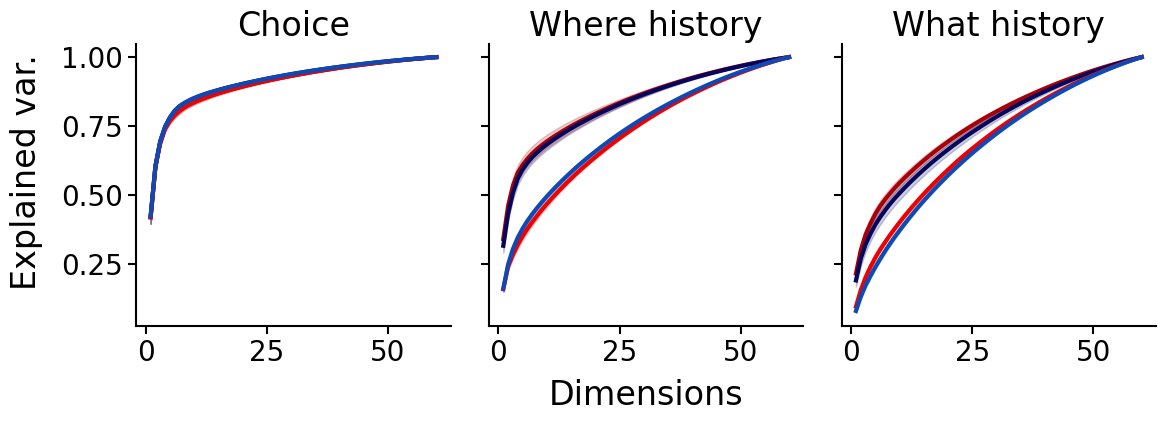

In [43]:
fig, axes = plt.subplots(1,3,figsize=(12, 4.8), sharey=True)

colors = ['#a70107', '#06065d', '#ed0101', '#0e49b5']

for idx_var in range(4):
    plot_mean_se(axes[0], np.arange(1, 61), np.cumsum(results_what_dicts[idx_var]['exp_vars'][0], 1),
                 color=colors[idx_var], label=None, axis=0)
axes[0].set_title('Choice')
    
for idx_var in range(4):
    plot_mean_se(axes[1], np.arange(1, 61), np.cumsum(results_where_dicts[idx_var]['exp_vars'][1], 1),
                 color=colors[idx_var], label=None, axis=0)
axes[1].set_title('Where history')
    
for idx_var in range(4):
    plot_mean_se(axes[2], np.arange(1, 61), np.cumsum(results_what_dicts[idx_var]['exp_vars'][1], 1),
                 color=colors[idx_var], label=None, axis=0)
axes[2].set_title('What history')

fig.supxlabel('Dimensions', x=0.55, y=0.1)
fig.supylabel('Explained var.', y=0.6)

sns.despine()
fig.tight_layout()


In [154]:
[len(results_where_dicts[0]['all_axes'][0][i]) for i in range(8)]

[542, 649, 637, 689, 834, 923, 994, 552]

In [168]:
for idx_dict in range(4):
    print(stats.pearsonr(np.concatenate([results_what_dicts[idx_dict]['all_axes'][0][i] for i in range(8)]), 
                         np.concatenate([results_what_dicts[idx_dict]['all_axes'][1][i] for i in range(8)])))

PearsonRResult(statistic=np.float64(0.049611065695056245), pvalue=np.float64(0.0001529111459021232))
PearsonRResult(statistic=np.float64(0.033955331519446144), pvalue=np.float64(0.009580703080672185))
PearsonRResult(statistic=np.float64(-0.028913209585826466), pvalue=np.float64(0.027401860879089548))
PearsonRResult(statistic=np.float64(-0.10346134755859354), pvalue=np.float64(2.5226948660618284e-15))


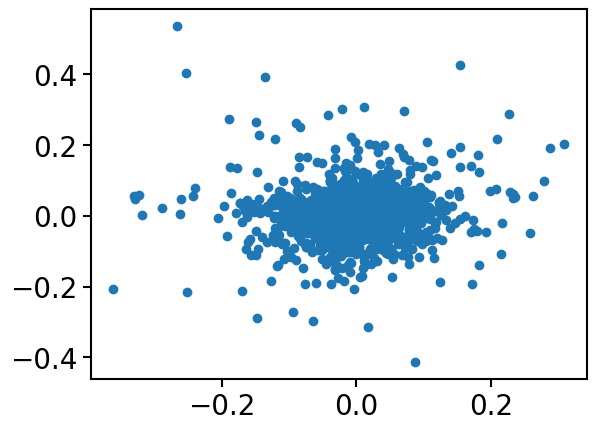

In [167]:
idx_dict = 1

plt.scatter(x=np.concatenate([results_what_dicts[idx_dict]['all_axes'][0][i] for i in range(8)]), 
            y=np.concatenate([results_what_dicts[idx_dict]['all_axes'][1][i] for i in range(8)]))

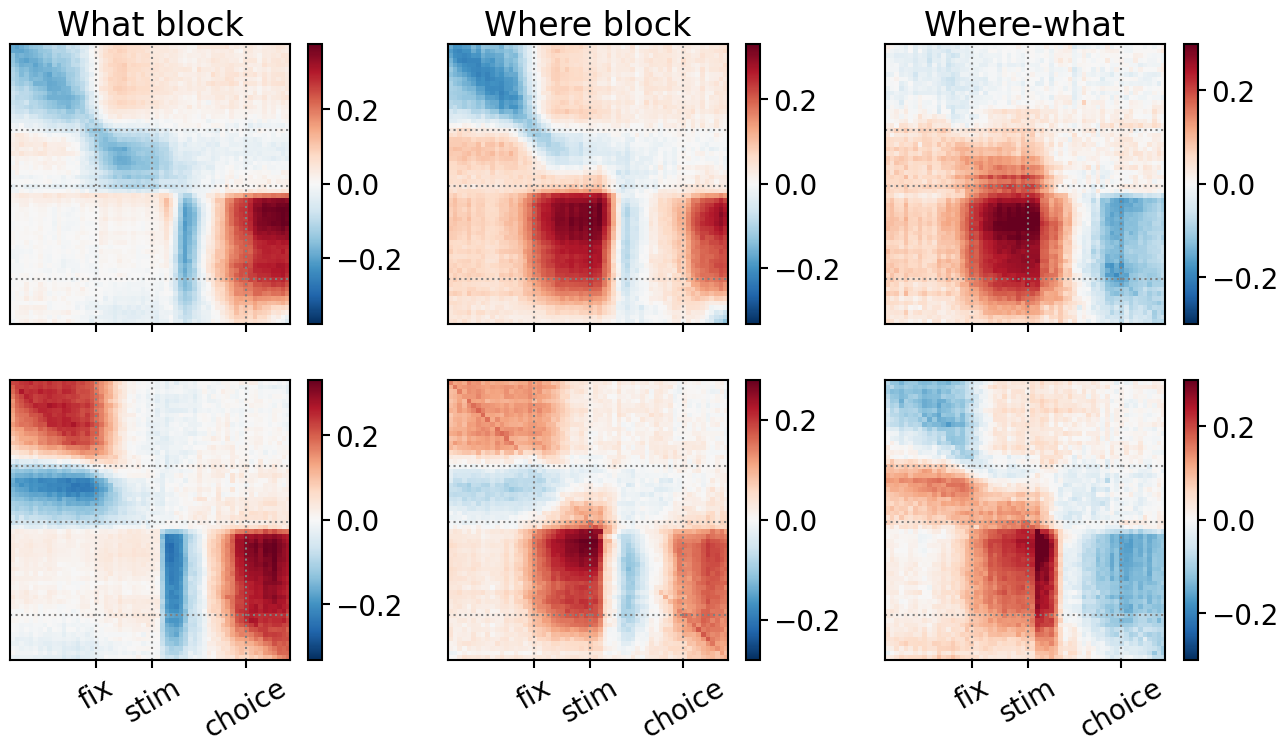

In [44]:
fig, axes = plt.subplots(2, 3, figsize=(16,8), sharex=True, sharey=True)

im = axes[0,0].imshow(results_where_dicts[0]['proj_corrs'], norm=mpl.colors.CenteredNorm(), cmap='RdBu_r')
fig.colorbar(im)
im = axes[0,1].imshow(results_where_dicts[1]['proj_corrs'], norm=mpl.colors.CenteredNorm(), cmap='RdBu_r')
fig.colorbar(im)
im = axes[0,2].imshow(results_where_dicts[1]['proj_corrs']-results_where_dicts[0]['proj_corrs'],
                norm=mpl.colors.CenteredNorm(halfrange=0.3), cmap='RdBu_r')
fig.colorbar(im)
axes[0,0].set_title('What block')
axes[0,1].set_title('Where block')
axes[0,2].set_title('Where-what')


im = axes[1,0].imshow(results_where_dicts[2]['proj_corrs'], norm=mpl.colors.CenteredNorm(), cmap='RdBu_r')
fig.colorbar(im)
im = axes[1,1].imshow(results_where_dicts[3]['proj_corrs'], norm=mpl.colors.CenteredNorm(), cmap='RdBu_r')
fig.colorbar(im)
im = axes[1,2].imshow(results_where_dicts[3]['proj_corrs']-results_where_dicts[2]['proj_corrs'],
                norm=mpl.colors.CenteredNorm(halfrange=0.3), cmap='RdBu_r')
fig.colorbar(im)

for axes_row in axes:
    for ax in axes_row:
        ax.axvline(50, ls=':', c='grey')
        ax.axhline(50, ls=':', c='grey')
        ax.axvline(30, ls=':', c='grey')
        ax.axhline(30, ls=':', c='grey')
        ax.axvline(18, ls=':', c='grey')
        ax.axhline(18, ls=':', c='grey')
        ax.set_xticks([18, 30, 50], ['fix', 'stim', 'choice'], rotation=30)
        ax.set_yticks([], [])

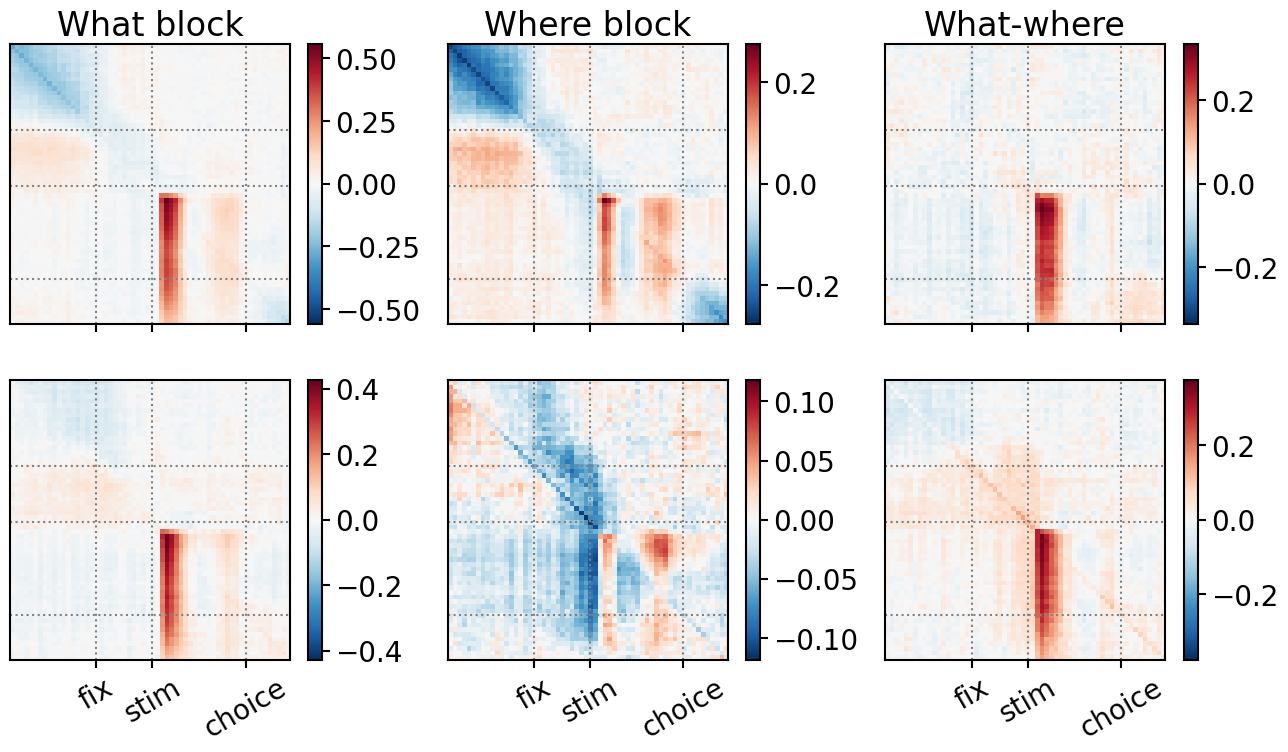

In [45]:
fig, axes = plt.subplots(2, 3, figsize=(16,8), sharex=True, sharey=True)

im = axes[0,0].imshow(results_what_dicts[0]['proj_corrs'], norm=mpl.colors.CenteredNorm(), cmap='RdBu_r')
fig.colorbar(im)
im = axes[0,1].imshow(results_what_dicts[1]['proj_corrs'], norm=mpl.colors.CenteredNorm(), cmap='RdBu_r')
fig.colorbar(im)
im = axes[0,2].imshow(results_what_dicts[0]['proj_corrs']-results_what_dicts[1]['proj_corrs'],
                norm=mpl.colors.CenteredNorm(), cmap='RdBu_r')
fig.colorbar(im)
axes[0,0].set_title('What block')
axes[0,1].set_title('Where block')
axes[0,2].set_title('What-where')


im = axes[1,0].imshow(results_what_dicts[2]['proj_corrs'], norm=mpl.colors.CenteredNorm(), cmap='RdBu_r')
fig.colorbar(im)
im = axes[1,1].imshow(results_what_dicts[3]['proj_corrs'], norm=mpl.colors.CenteredNorm(), cmap='RdBu_r')
fig.colorbar(im)
im = axes[1,2].imshow(results_what_dicts[2]['proj_corrs']-results_what_dicts[3]['proj_corrs'],
                norm=mpl.colors.CenteredNorm(), cmap='RdBu_r')
fig.colorbar(im)

for axes_row in axes:
    for ax in axes_row:
        ax.axvline(50, ls=':', c='grey')
        ax.axhline(50, ls=':', c='grey')
        ax.axvline(30, ls=':', c='grey')
        ax.axhline(30, ls=':', c='grey')
        ax.axvline(18, ls=':', c='grey')
        ax.axhline(18, ls=':', c='grey')
        ax.set_xticks([18, 30, 50], ['fix', 'stim', 'choice'], rotation=30)
        ax.set_yticks([], [])

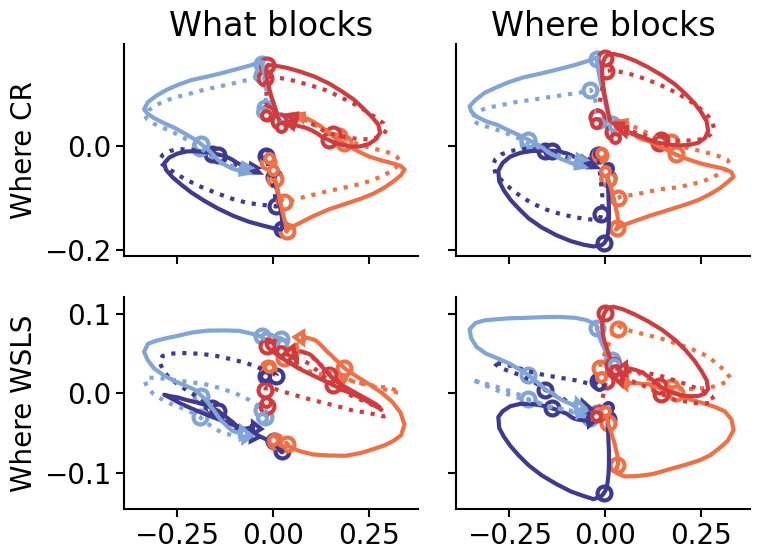

In [46]:
fig, axes = plt.subplots(2,2, sharex=True, sharey='row', figsize=(8, 6))

for i in range(2):
    for j in range(2):
        plot_proj_psths(results_where_dicts[i*2+j]['proj_cond_avg'], axes[i,j])
        
axes[0,0].set_ylabel('Where CR')
axes[1,0].set_ylabel('Where WSLS')

axes[0,0].set_title('What blocks')
axes[0,1].set_title('Where blocks')

#                 ['Rewarded loc', 'Loc of rewarded img']]

sns.despine()
fig.tight_layout()



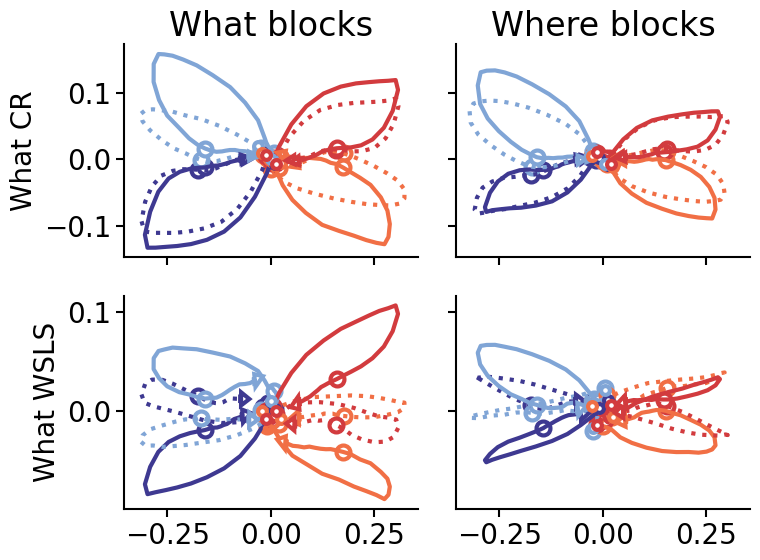

In [47]:
fig, axes = plt.subplots(2,2, sharex=True, sharey='row', figsize=(8, 6))

for i in range(2):
    for j in range(2):
        plot_proj_psths(results_what_dicts[i*2+j]['proj_cond_avg'], axes[i,j])

axes[0,0].set_ylabel('What CR')
axes[1,0].set_ylabel('What WSLS')

axes[0,0].set_title('What blocks')
axes[0,1].set_title('Where blocks')
        
sns.despine()
fig.tight_layout()



100%|██████████| 8/8 [00:03<00:00,  2.36it/s]


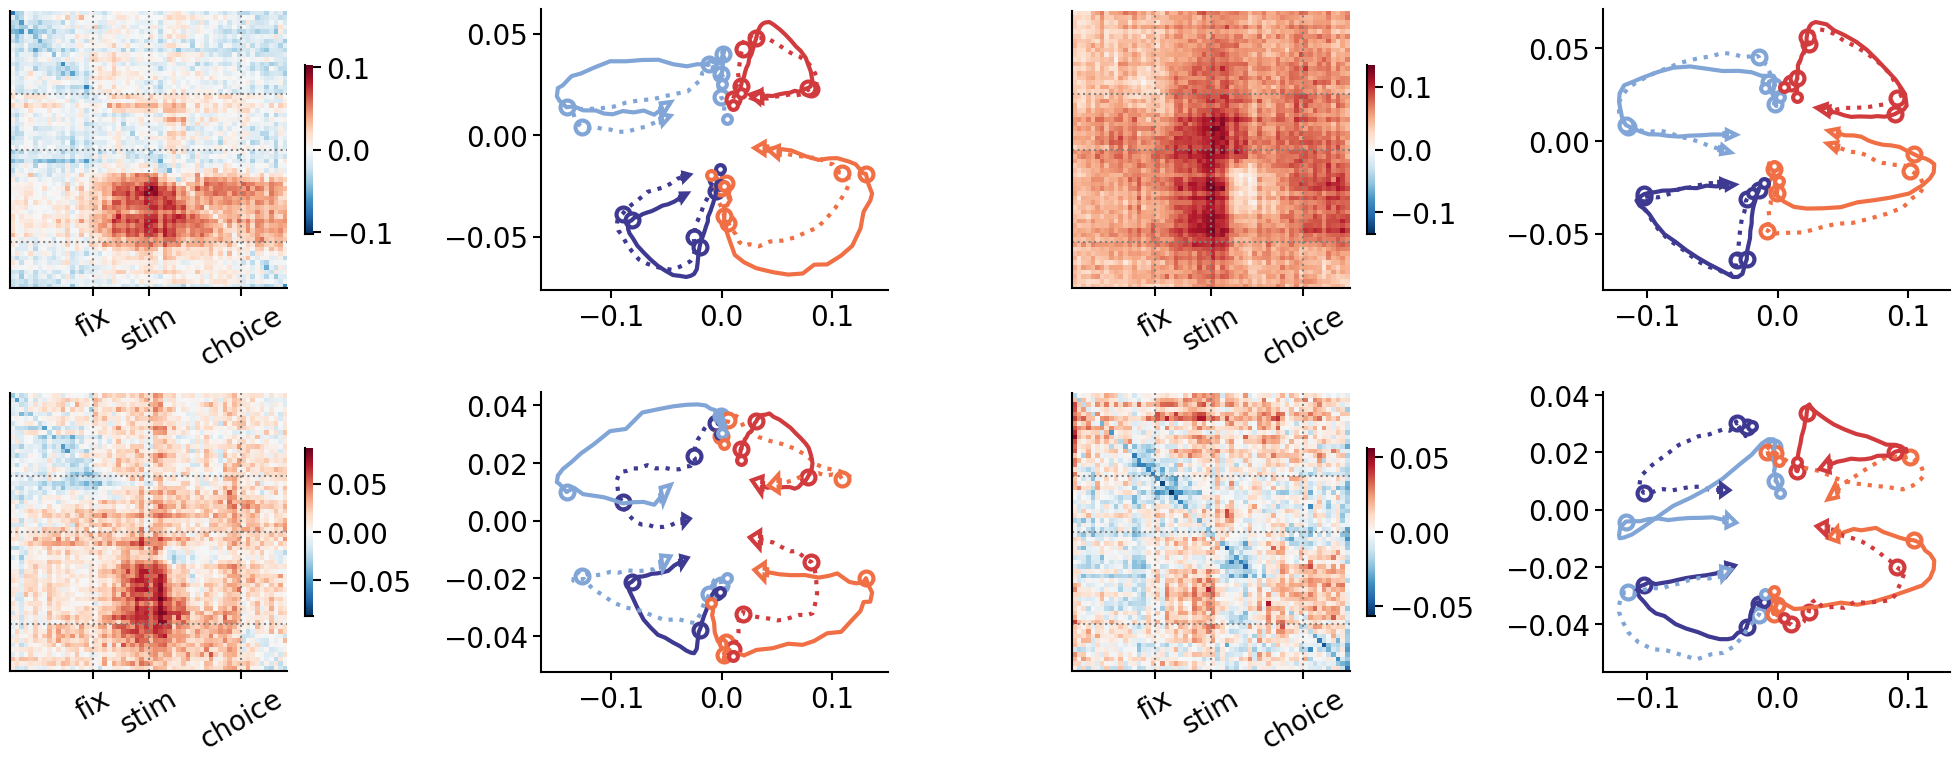

In [38]:
fig, axes = plt.subplots(2,4, figsize=(20,8))

plot_choice_history_state_space(
    all_sess_neural_data, all_sess_regression_info['betas'], all_sess_task_info,
    lambda x, y: np.sum(x[...,48:71]*y, -1), 
    lambda x, y: np.sum(x[...,76:99]*y, -1),
    lambda x: x[1:,0], lambda x: x[:-1,0], lambda x: x[:-1,2], lambda x: x[1:,4], 
    1, axes[0,0:2], False, True
)

plot_choice_history_state_space(
    all_sess_neural_data, all_sess_regression_info['betas'], all_sess_task_info,
    lambda x, y: np.sum(x[...,48:71]*y, -1), 
    lambda x, y: np.sum(x[...,76:99]*y, -1),
    lambda x: x[1:,0], lambda x: x[:-1,0], lambda x: x[:-1,2], lambda x: x[1:,4], 
    2, axes[0,2:4], False, True
)

plot_choice_history_state_space(
    all_sess_neural_data, all_sess_regression_info['betas'], all_sess_task_info,
    lambda x, y: np.sum(x[...,48:71]*y, -1), 
    lambda x, y: np.sum(x[...,106:129]*y, -1),
    lambda x: x[1:,0], lambda x: x[:-1,0], lambda x: x[:-1,2], lambda x: x[1:,4], 
    1, axes[1,0:2], True, True
)

plot_choice_history_state_space(
    all_sess_neural_data, all_sess_regression_info['betas'], all_sess_task_info,
    lambda x, y: np.sum(x[...,48:71]*y, -1), 
    lambda x, y: np.sum(x[...,106:129]*y, -1),
    lambda x: x[1:,0], lambda x: x[:-1,0], lambda x: x[:-1,2], lambda x: x[1:,4], 
    2, axes[1,2:4], True, True
)


sns.despine()
# axes[1,1].legend(bbox_to_anchor=(1.1,1.2))

fig.tight_layout()

## Dynamic arbitration signal

In [351]:
def trialwise_subspace_alignment(neural_data, task_info, betas, betas_func, axes):
    # neural_data should be num_trials X num_neurons X num_timesteps
    # trial_indices should be num_trials
    # block_types should be num_trials
    # subspace should be num_neurons X num_timesteps
    
    num_sess = len(neural_data)
        
    num_trials, num_neurons, num_timesteps = neural_data[0].shape
    
    num_trials_per_block = np.max(task_info[0][:,5]).astype(int)
    num_blocks = 24
    
    all_sess_alignment = np.empty((num_sess, num_blocks, num_trials_per_block, num_timesteps))*np.nan
    
    all_task_proj = []
            
    for idx_sess in tqdm.tqdm(range(num_sess)):
        subspace = betas_func(betas[idx_sess])
        normed_subspace = subspace/(np.linalg.norm(subspace, axis=0, keepdims=True)+1e-8)
        
        centered_neural_data = neural_data[idx_sess]-neural_data[idx_sess].mean(0)
                
        curr_sess_alignment = (centered_neural_data*normed_subspace.T[None]).sum(-2)
        
        valid_trial_masks = task_info[idx_sess][:,7]<=24
        
        block_idxs = task_info[idx_sess][valid_trial_masks,7].astype(int)-1
        trial_idxs = task_info[idx_sess][valid_trial_masks,5].astype(int)-1
        block_type = -(task_info[idx_sess][valid_trial_masks,3]*2-3)
        curr_sess_alignment = curr_sess_alignment[valid_trial_masks]
                
        all_sess_alignment[idx_sess, block_idxs, trial_idxs, :] = block_type[:,None]*curr_sess_alignment
        all_task_proj.append(curr_sess_alignment[1:])
    
#     all_task_alignment = np.concatenate(all_task_alignment)
    
    plot_mean_se(axes[0], np.arange(1, num_trials_per_block+1), 
                 all_sess_alignment.reshape((num_sess*num_blocks, num_trials_per_block, num_timesteps)).mean(-1),
                 color='k', label=None, axis=0)
    axes[0].set_xticks(np.arange(10, 80, 20), np.arange(10, 80, 20), rotation=0)
    axes[0].set_xlabel('Trial number')

    
    cmap = mpl.colormaps['plasma']
    chunks = 8
    trials_per_chunk = 80//chunks
    colors = cmap(np.linspace(0, 1, chunks))
    
    
    for idx_chunk in range(chunks):    
        curr_block_alignment = \
            all_sess_alignment[:,:,idx_chunk*trials_per_chunk:(idx_chunk+1)*trials_per_chunk].reshape((-1, num_timesteps))
        plot_mean_se(axes[1], xxx, curr_block_alignment,
                     color=colors[idx_chunk], axis=0,
                     label=str(idx_chunk*trials_per_chunk+1)+'-'+str((idx_chunk+1)*trials_per_chunk))
    axes[1].set_xticks([-600, 0, 1000], ['fix', 'stim', 'choice'], rotation=0)
    axes[1].set_xlabel('Timestep')
    axes[1].legend(bbox_to_anchor=(1,1), frameon=False, labelspacing=0.1, title='Trial chunk')

    axes[0].set_ylabel('Projection')
    
    return all_task_proj
        

100%|██████████| 8/8 [00:02<00:00,  3.15it/s]


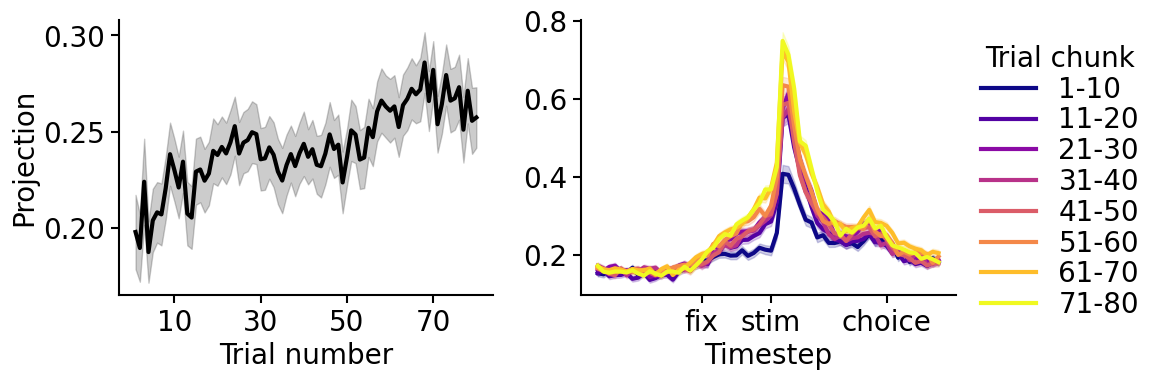

In [352]:
fig, axes = plt.subplots(1,2, figsize=(12, 4.2))

betas_func = lambda x: x[...,1]

all_task_proj = trialwise_subspace_alignment(all_sess_neural_data, all_sess_task_info, 
                             all_sess_regression_info['betas'],
                             betas_func, axes)

# fig.supylabel('Trial')
# fig.supxlabel('Timestep', y=0.05)
fig.tight_layout()
sns.despine()


In [31]:
def alignment_perf_corr(neural_data, task_info, betas, betas_func, axes):
    # neural_data should be num_trials X num_neurons X num_timesteps
    # trial_indices should be num_trials
    # block_types should be num_trials
    # subspace should be num_neurons X num_timesteps
    
    num_sess = len(neural_data)
    
    num_trials, num_neurons, num_timesteps = neural_data[0].shape
    
    num_blocks = 24
    
    all_sess_alignment = []
    all_sess_block_perf = []
    
    for idx_sess in tqdm.tqdm(range(num_sess)):
        subspace = betas_func(betas[idx_sess])
        
        normed_subspace = subspace/(np.linalg.norm(subspace, axis=0, keepdims=True)+1e-8)
        
        centered_neural_data = neural_data[idx_sess]-neural_data[idx_sess].mean(0)
        
        curr_sess_alignment = (centered_neural_data*normed_subspace.T[None]).sum(-2).mean(1) # num_trials
        
        for idx_block in range(num_blocks):
            curr_trial_mask = task_info[idx_sess][:,7]==idx_block+1
            block_type = np.median(task_info[idx_sess][curr_trial_mask,3])
            all_sess_alignment.append(
                -(block_type*2-3)*np.sum(curr_sess_alignment[curr_trial_mask], axis=0)/curr_trial_mask.sum())
            all_sess_block_perf.append(np.sum(task_info[idx_sess][curr_trial_mask,2], axis=0)/curr_trial_mask.sum())
        
    
    all_sess_alignment = np.array(all_sess_alignment)
    all_sess_block_perf = np.array(all_sess_block_perf)


    fig, ax = plt.subplots(figsize=(6, 4))
    sns.regplot(x=all_sess_alignment, y=all_sess_block_perf, ax=ax, color='grey',
               scatter_kws={'s': 40, 'linewidths': 2}, line_kws={'lw': 4, 'color': 'k'})
    ax.set_xlabel('Task representation')
    ax.set_ylabel('Performance')
    sns.despine()
    
    print(stats.spearmanr(all_sess_alignment, all_sess_block_perf))
    
    return 


100%|██████████| 8/8 [00:02<00:00,  3.68it/s]

SignificanceResult(statistic=np.float64(0.292626686394711), pvalue=np.float64(3.808518989196281e-05))


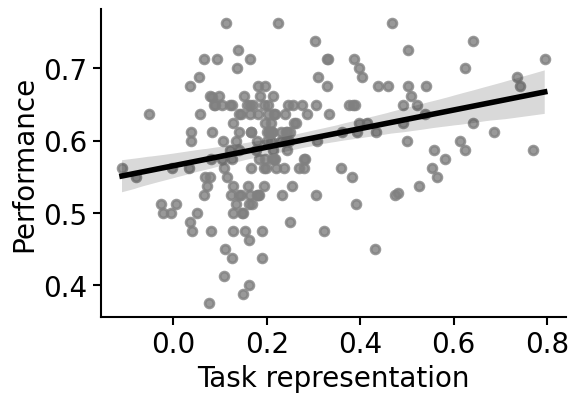

In [32]:
alignment_perf_corr(all_sess_neural_data, all_sess_task_info, all_sess_regression_info['betas'], betas_func, axes)

## Correlation between arbitration and representation strength

In [399]:
def task_belief_var_compression_routing(all_task_proj, all_hist_proj, all_ch_proj, all_sess_task_info, window):
    
    all_block_avg_hist_proj = []
    all_block_avg_task_proj = []
    all_block_hist_choice_corr = []

    for idx_sess in tqdm.tqdm(range(len(all_task_alignment))):

        combined_hist_proj = np.empty_like(all_task_proj[idx_sess])
        combined_ch_proj = np.empty_like(all_task_proj[idx_sess])

        valid_trial_mask = all_sess_task_info[idx_sess][1:,7]<=24
        curr_sess_blocks_types = all_sess_task_info[idx_sess][1:,3][valid_trial_mask]
        curr_sess_block_ids = all_sess_task_info[idx_sess][1:,7][valid_trial_mask]

        what_trials_mask = (curr_sess_blocks_types==1)
        combined_hist_proj[what_trials_mask] = all_hist_proj[0][idx_sess]
        combined_ch_proj[what_trials_mask] = all_ch_proj[0][idx_sess]

        where_trials_mask =(curr_sess_blocks_types==2)
        combined_hist_proj[where_trials_mask] = all_hist_proj[1][idx_sess]
        combined_ch_proj[where_trials_mask] = all_ch_proj[1][idx_sess]

        block_avg_hist_proj = np.empty(24)*np.nan
        block_avg_task_proj = np.empty(24)*np.nan
        block_avg_hist_choice_corr = np.empty(24)*np.nan

        for idx_block in range(1,25):
            block_avg_hist_proj[idx_block-1] = np.mean(np.abs(combined_hist_proj[curr_sess_block_ids==idx_block])[:,window[1][0]:window[1][1]])
            block_avg_task_proj[idx_block-1] = np.mean(all_task_alignment[idx_sess][curr_sess_block_ids==idx_block])
            block_avg_hist_choice_corr[idx_block-1] = \
                np.corrcoef(combined_ch_proj[curr_sess_block_ids==idx_block].T, 
                            combined_hist_proj[curr_sess_block_ids==idx_block].T)\
                            [window[0][0]:window[0][1], 60+window[1][0]:60+window[1][1]].mean()

        all_block_avg_hist_proj.append(block_avg_hist_proj)
        all_block_avg_task_proj.append(block_avg_task_proj)
        all_block_hist_choice_corr.append(block_avg_hist_choice_corr)

    all_block_avg_hist_proj = np.concatenate(all_block_avg_hist_proj)
    all_block_avg_task_proj = np.concatenate(all_block_avg_task_proj)
    all_block_hist_choice_corr = np.concatenate(all_block_hist_choice_corr)

    return all_block_avg_hist_proj, all_block_avg_task_proj, all_block_hist_choice_corr


In [406]:
all_vars_avg_hist_proj = []
all_vars_avg_task_proj = []
all_vars_hist_choice_corr = []

curr_var_hist_proj, curr_var_task_proj, curr_var_hist_choice_corr = \
    task_belief_var_compression_routing(all_task_proj, [results_where_dicts[0]['all_proj'][1], results_where_dicts[1]['all_proj'][1]],
                                       [results_where_dicts[0]['all_proj'][0], results_where_dicts[1]['all_proj'][0]], 
                                       all_sess_task_info, [[30, 60], [18, 30]])
all_vars_avg_hist_proj.append(curr_var_hist_proj)
all_vars_avg_task_proj.append(curr_var_task_proj)
all_vars_hist_choice_corr.append(curr_var_hist_choice_corr)

curr_var_hist_proj, curr_var_task_proj, curr_var_hist_choice_corr = \
    task_belief_var_compression_routing(all_task_proj, [results_where_dicts[2]['all_proj'][1], results_where_dicts[3]['all_proj'][1]],
                                       [results_where_dicts[2]['all_proj'][0], results_where_dicts[3]['all_proj'][0]], 
                                       all_sess_task_info, [[30, 60], [18, 30]])
all_vars_avg_hist_proj.append(curr_var_hist_proj)
all_vars_avg_task_proj.append(curr_var_task_proj)
all_vars_hist_choice_corr.append(curr_var_hist_choice_corr)


curr_var_hist_proj, curr_var_task_proj, curr_var_hist_choice_corr = \
    task_belief_var_compression_routing(all_task_proj, [results_what_dicts[0]['all_proj'][1], results_what_dicts[1]['all_proj'][1]],
                                       [results_what_dicts[0]['all_proj'][0], results_what_dicts[1]['all_proj'][0]], 
                                       all_sess_task_info, [[30, 60], [30, 40]])
all_vars_avg_hist_proj.append(curr_var_hist_proj)
all_vars_avg_task_proj.append(curr_var_task_proj)
all_vars_hist_choice_corr.append(curr_var_hist_choice_corr)


curr_var_hist_proj, curr_var_task_proj, curr_var_hist_choice_corr = \
    task_belief_var_compression_routing(all_task_proj, [results_what_dicts[2]['all_proj'][1], results_what_dicts[3]['all_proj'][1]],
                                       [results_what_dicts[2]['all_proj'][0], results_what_dicts[3]['all_proj'][0]], 
                                       all_sess_task_info, [[30, 60], [30, 40]])
all_vars_avg_hist_proj.append(curr_var_hist_proj)
all_vars_avg_task_proj.append(curr_var_task_proj)
all_vars_hist_choice_corr.append(curr_var_hist_choice_corr)




100%|██████████| 8/8 [00:00<00:00, 206.78it/s]


SignificanceResult(statistic=np.float64(-0.12572226894175734), pvalue=np.float64(0.08228409883541973))
SignificanceResult(statistic=np.float64(0.34091263597645344), pvalue=np.float64(1.3067865243460305e-06))
SignificanceResult(statistic=np.float64(-0.2220943086563763), pvalue=np.float64(0.001960881801846627))
SignificanceResult(statistic=np.float64(0.19284072104820554), pvalue=np.float64(0.00736592114882001))


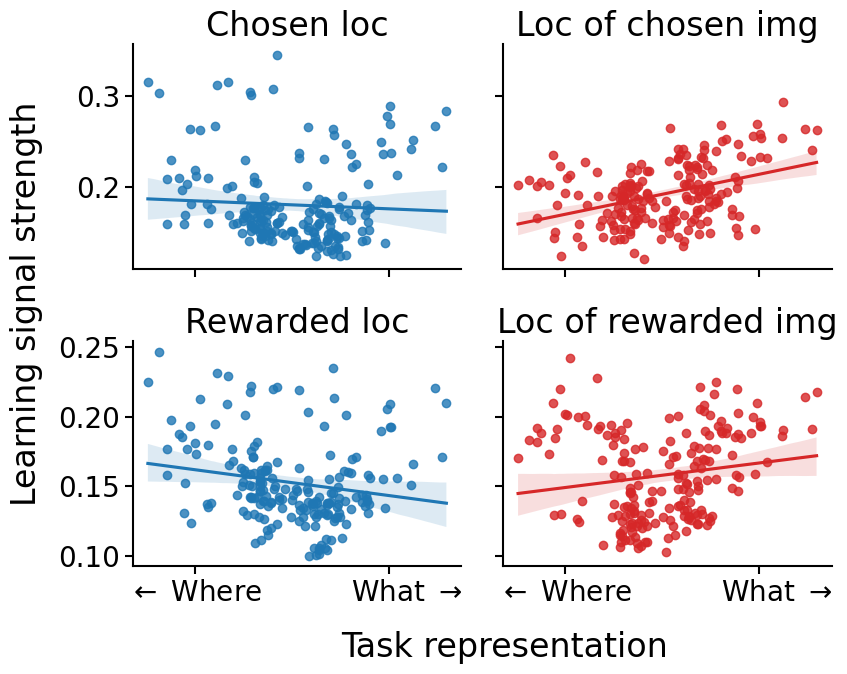

In [438]:
ylabel_names = [['Chosen loc', 'Loc of chosen img'],
                ['Rewarded loc', 'Loc of rewarded img']]
colors = ['tab:blue', 'tab:red']


fig, axes = plt.subplots(2,2, sharex=True, sharey='row', figsize=(9,7.2))


for i in range(2):
    for j in range(2):
        sns.regplot(x=all_vars_avg_task_proj[i+j*2], y=all_vars_avg_hist_proj[i+j*2], 
                    ax=axes[i,j], color=colors[j])
        print(stats.spearmanr(all_vars_avg_task_proj[i+j*2], all_vars_avg_hist_proj[i+j*2]))
        axes[i,j].set_title(ylabel_names[i][j])
        axes[i,j].set_xticks([-0.5, 0.5], [r'$\leftarrow$ Where', r'    What $\rightarrow$'])

fig.supxlabel('Task representation', x=0.6, y=0.05)
fig.supylabel('Learning signal strength', x=0.05, y=0.55)
        
sns.despine()
fig.tight_layout()

SignificanceResult(statistic=np.float64(-0.6607709627539811), pvalue=np.float64(1.8421780457722583e-25))
SignificanceResult(statistic=np.float64(0.5119903426199713), pvalue=np.float64(3.1947352702729956e-14))
SignificanceResult(statistic=np.float64(-0.5389584407129101), pvalue=np.float64(7.361004806375544e-16))
SignificanceResult(statistic=np.float64(0.5424934894067223), pvalue=np.float64(4.3781442537198973e-16))


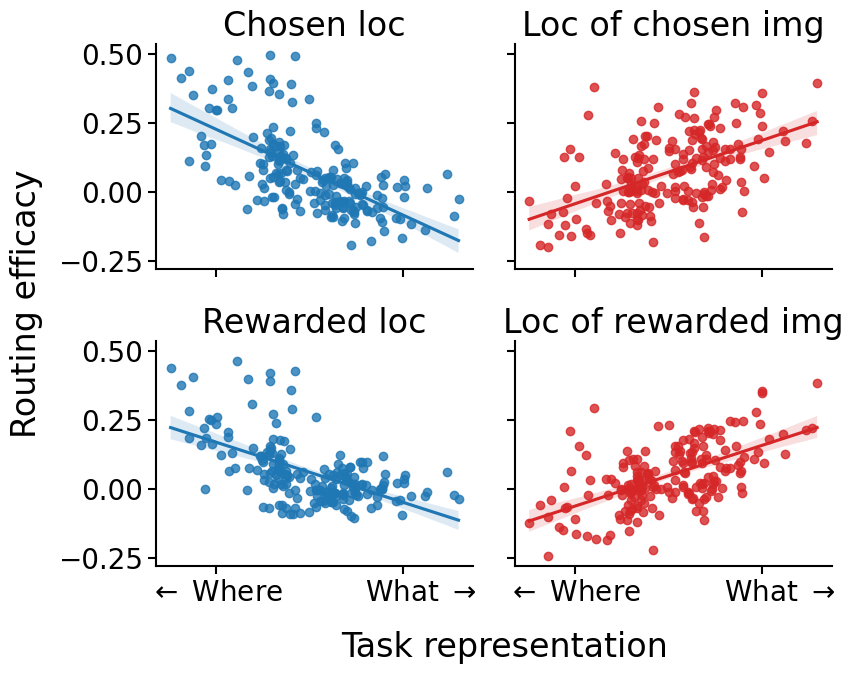

In [441]:
ylabel_names = [['Chosen loc', 'Loc of chosen img'],
                ['Rewarded loc', 'Loc of rewarded img']]

colors = ['tab:blue', 'tab:red']


fig, axes = plt.subplots(2,2, sharex=True, sharey=True, figsize=(9, 7.2))

for i in range(2):
    for j in range(2):
        sns.regplot(x=all_vars_avg_task_proj[i+j*2], y=all_vars_hist_choice_corr[i+j*2], 
                    ax=axes[i,j], color=colors[j])
        print(stats.spearmanr(all_vars_avg_task_proj[i+j*2], all_vars_hist_choice_corr[i+j*2]))
        axes[i,j].set_title(ylabel_names[i][j])
        axes[i,j].set_xticks([-0.5, 0.5], [r'$\leftarrow$ Where', r'    What $\rightarrow$'])

fig.supxlabel('Task representation', x=0.6, y=0.05)
fig.supylabel('Routing efficacy', x=0.05, y=0.55)

sns.despine()
fig.tight_layout()